Nie przeszukiwać całej przestrzeni, dodać coś zachłannego

spychamy do prawej góry  
crossover to wybór fragmentu okręgu z jednego osobnika, reszty z drugiego  
mutacja to wyrzucenie losowego prostokąta z grupy najmniej wartościowych value/(width*height), przepchnięcie tak powstałej układanki do brzegu, i dodanie nowych prostokątów na wierzch

X, Y - lewy dolny róg prostokąta

In [172]:
import random
import numpy as np
import pandas as pd
import math
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import copy
import operator
import time

In [345]:
def show_individual(genes, radius):
    fig, ax = plt.subplots(figsize = (8,8))
    plt.xlim([-radius*1.05, radius*1.05])
    plt.ylim([-radius*1.05, radius*1.05])

    ax.add_patch(plt.Circle((0,0), radius, fill = False))
    for i, gene in enumerate(genes):
        ax.add_patch(plt.Rectangle((gene.x, gene.y), gene.width, gene.height, fill = False, lw = 1, ec = 'blue'))
        plt.scatter([gene.x+gene.width/2], [gene.y+gene.height/2], c='purple', s = 100, marker = f'${i}$')
    plt.show()

In [412]:
class Gene:
    def __init__(self, x, y, width, height, value):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.value = value

    def __str__(self):
        return f"x : {self.x}, 'y' : {self.y}, 'width' : {self.width}, 'height' : {self.height}, 'value' : {self.value}"

    def rotate(self):
        tmp = self.height
        self.height = self.width
        self.width = tmp

class Rectangle:
    def __init__(self, width, height, value):
        self.width = width
        self.height = height
        self.value = value

def rect_overlap(x1, y1, w1, h1, x2, y2, w2, h2):
    if (x1 + w1 <= x2) or (x2 + w2 <= x1):
        return False  # No horizontal overlap
    
    if (y1 + h1 <= y2) or (y2 + h2 <= y1):
        return False  # No vertical overlap
    
    return True  # Overlap exists

def rect_overlap2(r1, r2):
    x1 = r1.x
    y1 = r1.y
    w1 = r1.width
    h1 = r1.height
    x2 = r2.x
    y2 = r2.y
    w2 = r2.width
    h2 = r2.height
    if (x1 + w1 <= x2) or (x2 + w2 <= x1):
        return False  # No horizontal overlap
    
    if (y1 + h1 <= y2) or (y2 + h2 <= y1):
        return False  # No vertical overlap
    
    return True  # Overlap exists


def in_circle(gene, radius):
    return all([gene.x**2 + gene.y**2 <= radius**2,
    (gene.x+gene.width)**2 + gene.y**2 <= radius**2,
    (gene.x+gene.width)**2 + (gene.y+gene.height)**2 <= radius**2,
    gene.x**2 + (gene.y+gene.height)**2 <= radius**2])

# def shuffle_rectangles(genome, radius, angle = 3*math.pi/2):
#     px, py = radius*math.cos(angle), radius*math.sin(angle) # point on the circle at the angle
#     # sort rectangles by their distance to the angle-bound point on the circle
#     sorted_genome = sorted( genome, key = lambda gene: ((gene.x - px)**2 + (gene.y - py)**2))
#     # pull rectangles one by one to that point:
#     for index, rect in enumerate(sorted_genome):
        
#     # 
#         for r2 in sorted_genome[:index]:

        

def generate_initial(radius, rectangles, n_tries = 1000):
    genes = []
    for _ in range(n_tries):
        overlap = False
        rect = rectangles.sample()
        x = random.uniform(-radius, radius)
        y = random.uniform(-radius, radius)
        if np.any([x**2 + y**2 > radius**2, x**2 + (y+rect.height.values[0])**2 > radius**2, (x+rect.width.values[0])**2 + y**2 > radius**2, (x+rect.width.values[0])**2 + (y+rect.height.values[0])**2 > radius**2]):
            continue
        for gene in genes:
            if rect_overlap(x, y, rect.width.values[0], rect.height.values[0], gene.x, gene.y, gene.width, gene.height):
                overlap = True
                break
        if not overlap:
            genes.append(Gene(x, y, rect.width.values[0], rect.height.values[0], rect.value.values[0]))
    return(genes)

def calc_angle(x,y):
    unit_vector_1 = [x,y] / np.linalg.norm([x,y])
    unit_vector_2 = [1,0]
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    return np.arccos(dot_product)

def cut_circle(genome, a, b):
    check = [(a < calc_angle(g.x, g.y)) and (calc_angle(g.x, g.y) < b) for g in genome]
    return list(np.array(genome)[check]), list(np.array(genome)[[(not c) for c in check]])


import copy
def shuffle(genome, radius, axis = 'down'):
    genome_queued = []
    if axis == 'left':
        genome_queued = sorted(genome, key = lambda gene: gene.x)
        for i, gene in enumerate(genome_queued):
            new_x = -math.sqrt( radius**2 - max([(gene.y)**2, (gene.y+gene.height)**2]))
            new_gene = copy.copy(gene)
            new_gene.x = new_x
            overlap = True
            prev_overlap = False
            while overlap and not (overlap is prev_overlap):
                prev_overlap = overlap
                overlap = False
                for k, r2 in enumerate(genome_queued[:i]):
                    if rect_overlap2(new_gene, r2):
                        overlap = r2
                        if prev_overlap is r2:
                            break
                        if r2.x+r2.width > new_x:
                            new_x = r2.x+r2.width
                            new_gene.x = new_x
                
            genome_queued[i] = new_gene

    if axis == 'right':
        genome_queued = sorted( genome, key = lambda gene: -gene.x )
        for i, gene in enumerate(genome_queued):
            new_x = math.sqrt( radius**2 - max([(gene.y)**2, (gene.y+gene.height)**2]))-gene.width

            new_gene = copy.copy(gene)
            new_gene.x = new_x
            overlap = True
            prev_overlap = False
            while overlap and not (overlap is prev_overlap):
                prev_overlap = overlap
                overlap = False
                for k, r2 in enumerate(genome_queued[:i]):
                    if rect_overlap2(new_gene, r2):
                        overlap = r2
                        if prev_overlap is r2:
                            break
                        if r2.x-new_gene.width < new_x:
                            new_x = r2.x-new_gene.width
                            new_gene.x = new_x
                            
            genome_queued[i] = new_gene

    if axis == 'down':
        genome_queued = sorted(genome, key = lambda gene: gene.y)
        for i, gene in enumerate(genome_queued):
            new_y = -math.sqrt( radius**2 - max([(gene.x)**2, (gene.x+gene.width)**2]))
            new_gene = copy.copy(gene)
            new_gene.y = new_y
            overlap = True
            prev_overlap = False
            while overlap and (not (overlap is prev_overlap)):
                prev_overlap = overlap
                overlap = False
                for k, r2 in enumerate(genome_queued[:i]):
                    if rect_overlap2(new_gene, r2):
                        overlap = r2
                        if prev_overlap is r2:
                            break
                        if r2.y+r2.height > new_y:
                            new_y = r2.y+r2.height
                            new_gene.y = new_y
            genome_queued[i] = new_gene


    genome_queued = [g for g in genome_queued if in_circle(g, radius)]
    return(genome_queued)


def delete_low_value(genome, count):
    if count > len(genome):
        count = len(genome)-1
    return sorted(genome, key = lambda g: -g.value/(g.height*g.width))[:len(genome)-count]



def populate(genome, radius, axis, ntries):
    
    if axis == 'down':
        for _ in range(ntries):
            rect = rectangles.sample()
            x = random.uniform(-radius, radius-rect.width.values[0])

            new_y = -math.sqrt( radius**2 - max((x+rect.width.values[0])**2,(x)**2) )

            new_gene = Gene(x, new_y, rect.width.values[0], rect.height.values[0], rect.value.values[0])

            overlap = True
            prev_overlap = False
            while overlap and (not(prev_overlap is overlap)):
                prev_overlap = overlap
                overlap = False
                for r2 in genome:
                    if rect_overlap2(new_gene, r2):
                        overlap = r2

                        if prev_overlap is r2:
                            break

                        if r2.y+r2.height > new_y:
                            new_y = r2.y+r2.height
                            new_gene.y = new_y

                if x**2 + new_y**2 > radius**2 or (prev_overlap is overlap):
                    break
                
            if not overlap:
                genome.append(new_gene)


    elif axis == 'left':
        for _ in range(ntries):
            rect = rectangles.sample()
            y = random.uniform(-radius, radius-rect.height.values[0])

            new_x = -math.sqrt( radius**2 - max((y+rect.height.values[0])**2,(y)**2) )

            new_gene = Gene(new_x, y, rect.width.values[0], rect.height.values[0], rect.value.values[0])

            overlap = True
            prev_overlap = False
            while overlap and (not(prev_overlap is overlap)):
                prev_overlap = overlap
                overlap = False
                for r2 in genome:
                    if rect_overlap2(new_gene, r2):
                        overlap = r2

                        if prev_overlap is r2:
                            break

                        if r2.x+r2.width > new_x:
                            new_x = r2.x+r2.width
                            new_gene.x = new_x
                if new_x**2 + y**2 > radius**2 or (overlap is prev_overlap):
                    break
                
            if not overlap:
                genome.append(new_gene)

    elif axis == 'right':
        for _ in range(ntries):
            rect = rectangles.sample()
            y = random.uniform(-radius, radius-rect.height.values[0])

            new_x = math.sqrt( radius**2 - max((y+rect.height.values[0])**2,(y)**2) )
            new_gene = Gene(new_x, y, rect.width.values[0], rect.height.values[0], rect.value.values[0])

            overlap = True
            while overlap:
                prev_overlap = overlap
                overlap = False
                for r2 in genome:
                    if rect_overlap2(new_gene, r2):
                        overlap = r2

                        if prev_overlap is r2:
                            break

                        if r2.x - new_gene.width < new_x:
                            new_x = r2.x - new_gene.width
                            new_gene.x = new_x
                if (new_x**2 + y**2 > radius**2) or (overlap is prev_overlap):
                    break
                
            if not overlap:
                genome.append(new_gene)


    genome = [g for g in genome if in_circle(g, radius)]
    return(genome)


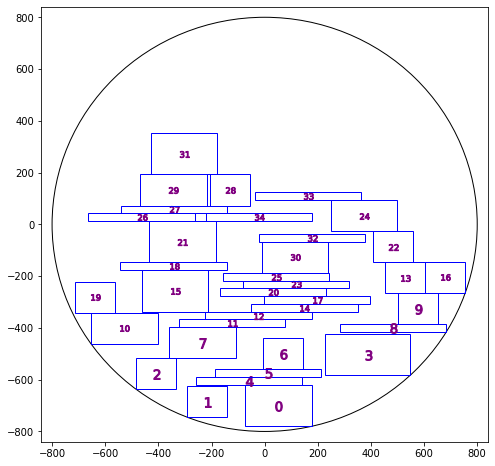

0 down 14380


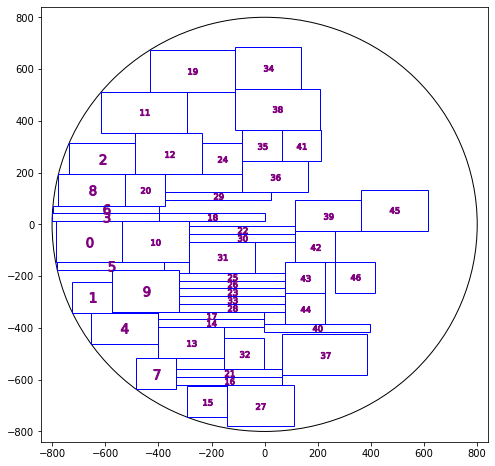

0 left 16380


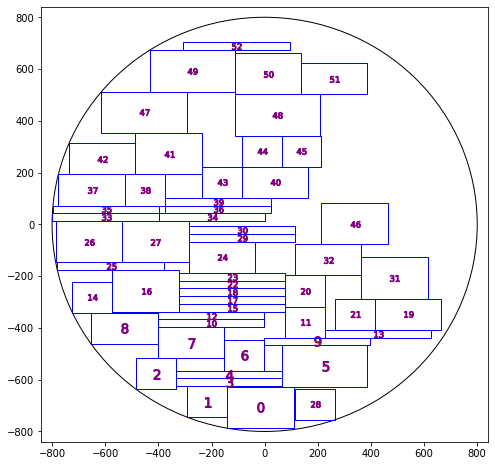

0 down 17040


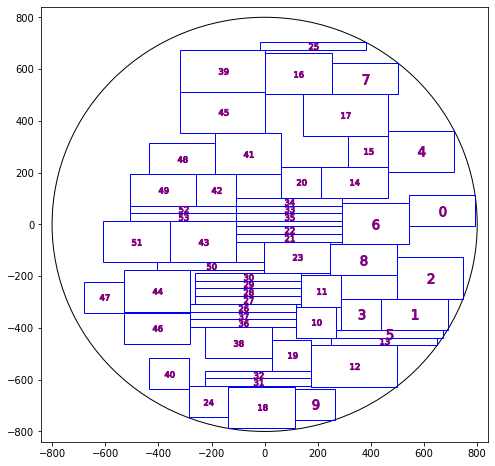

0 right 17400


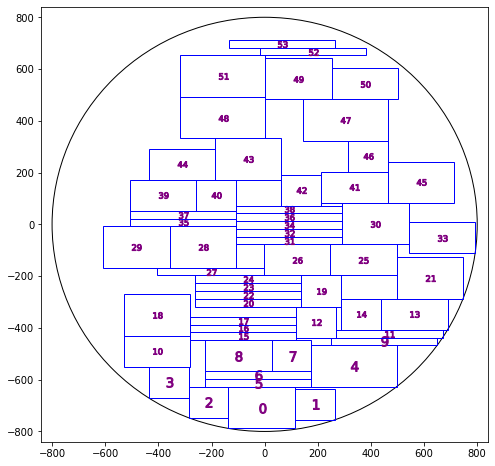

1 down 17860


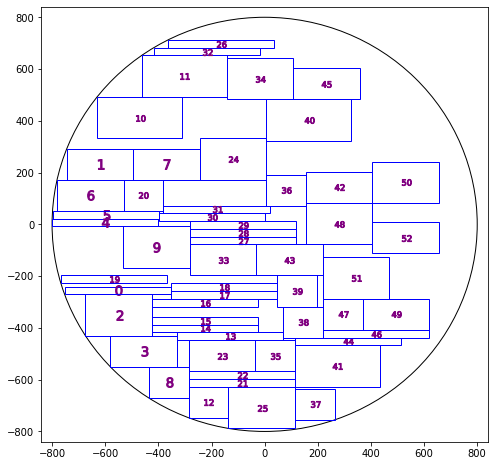

1 left 18000


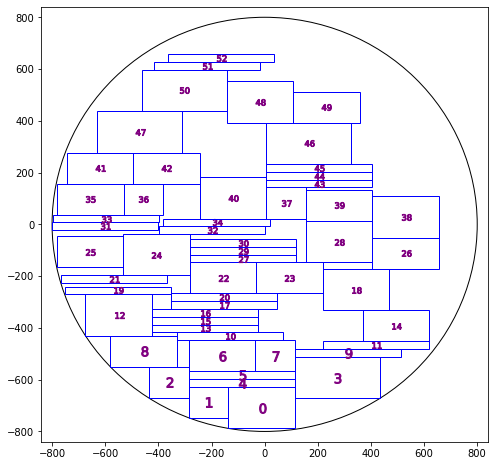

1 down 18200


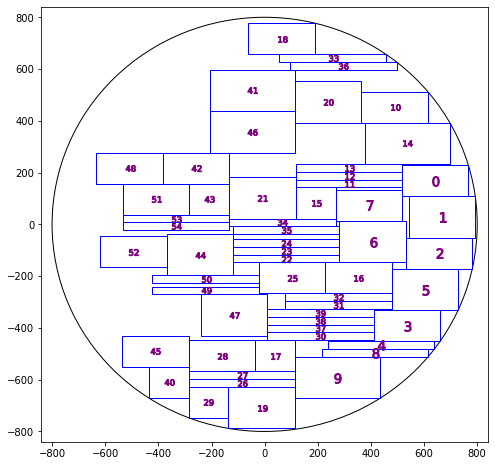

1 right 18740


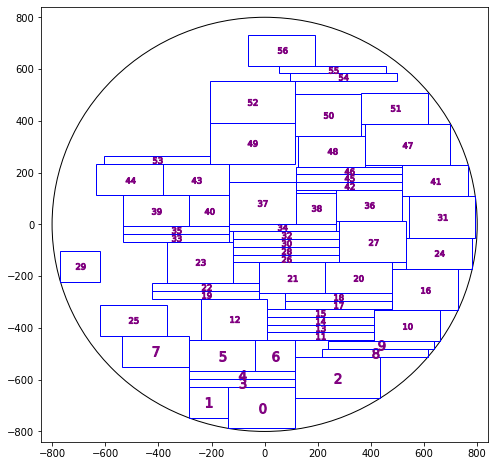

2 down 20260


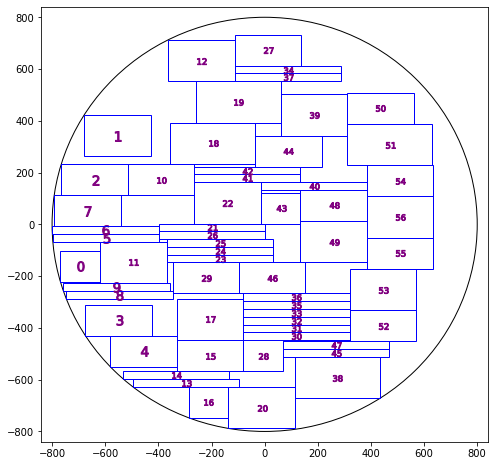

2 left 19340


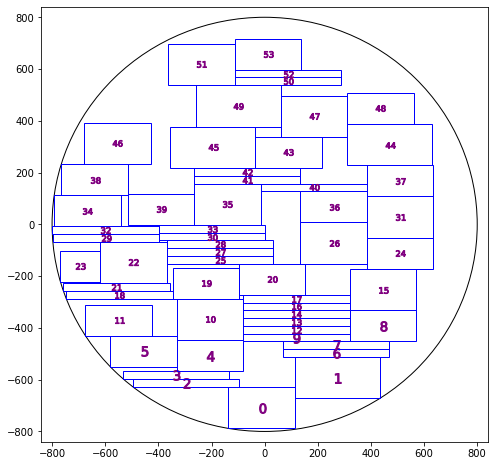

2 down 19660


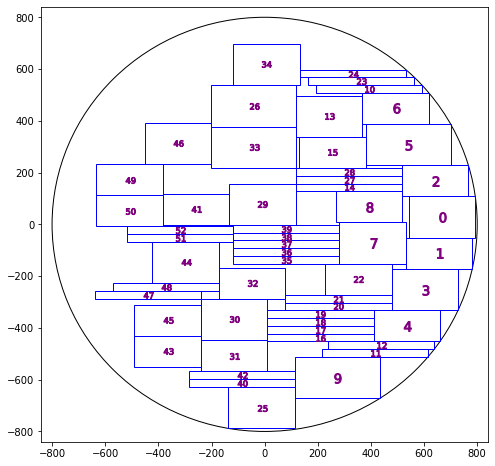

2 right 19700


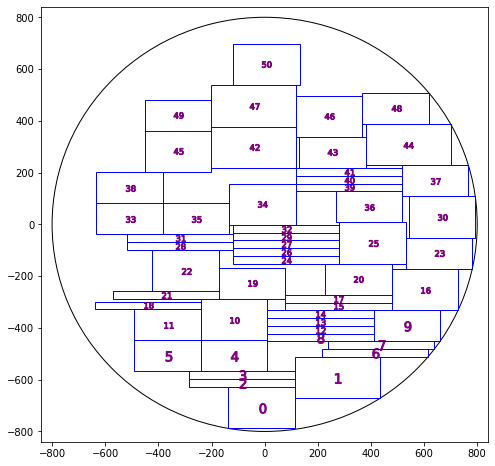

3 down 18520


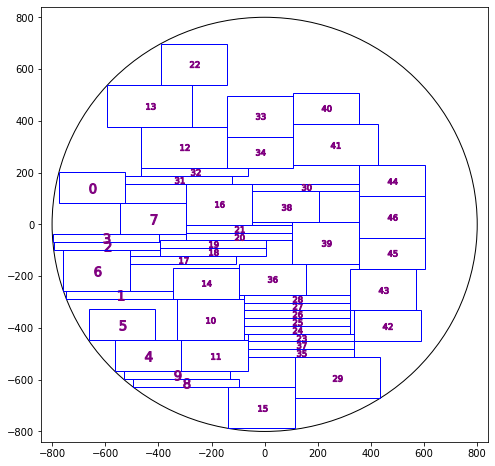

3 left 18080


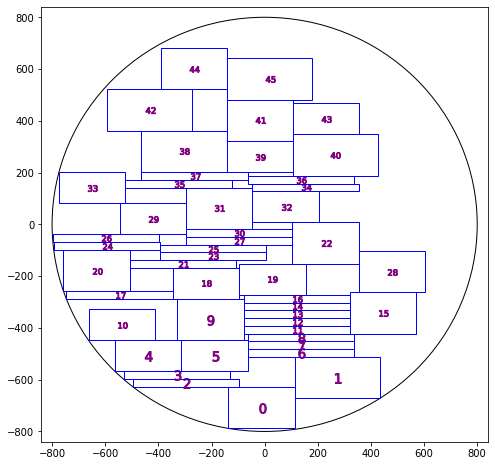

3 down 19780


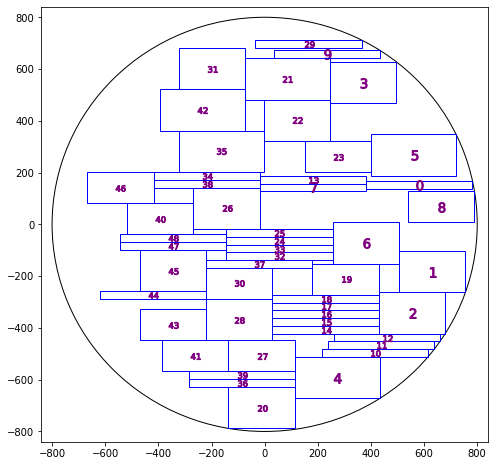

3 right 19760


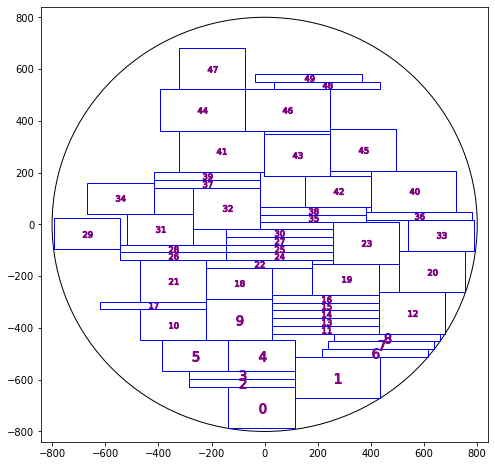

4 down 20260


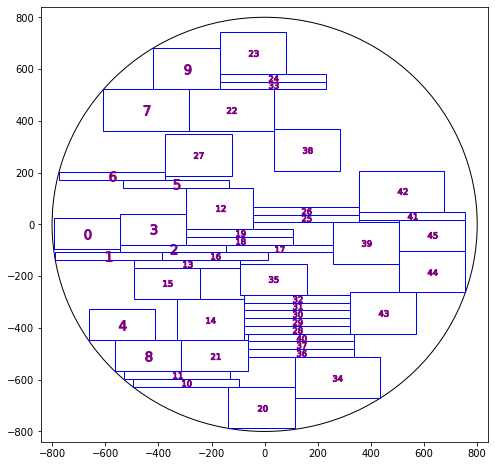

4 left 20440


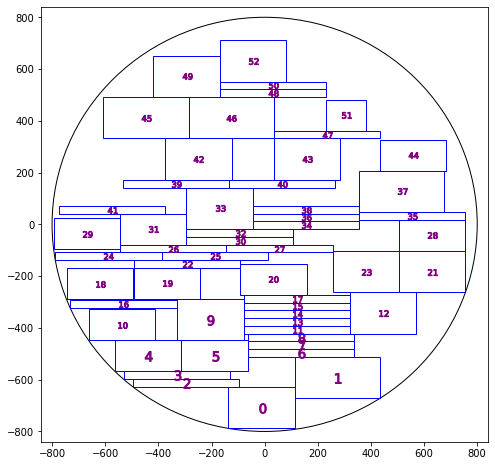

4 down 20360


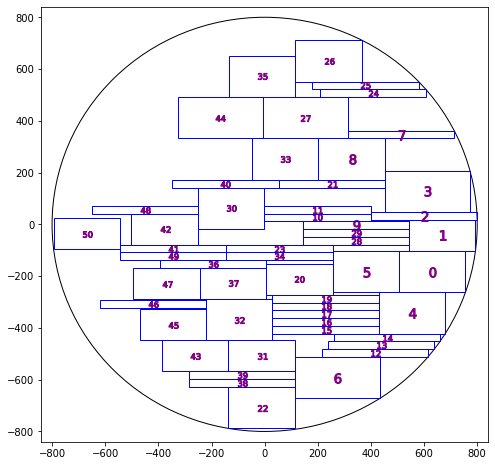

4 right 21160


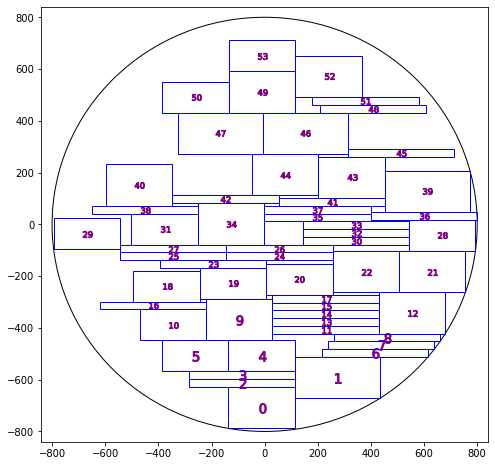

5 down 21680


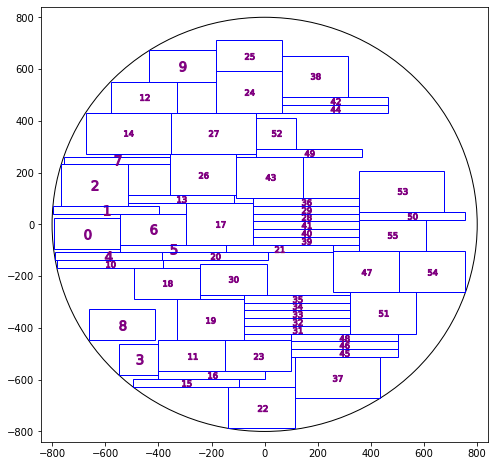

5 left 21500


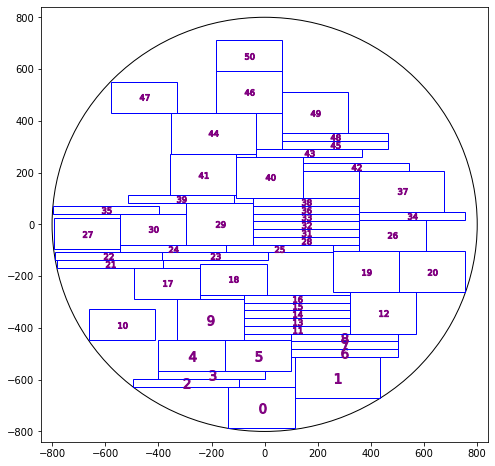

5 down 20120


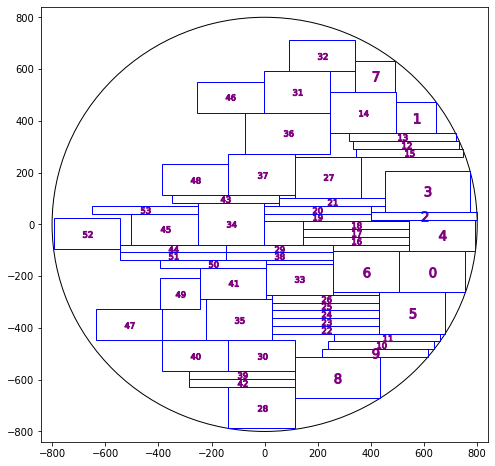

5 right 21220


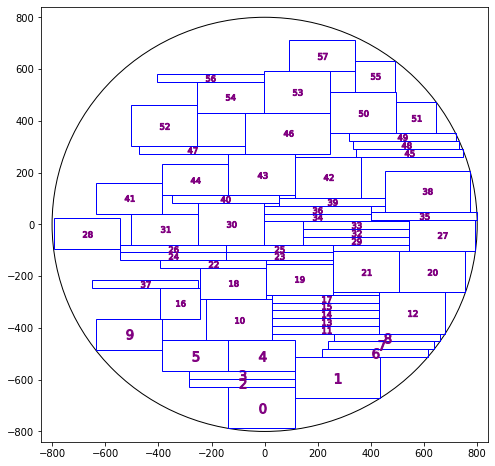

6 down 22080


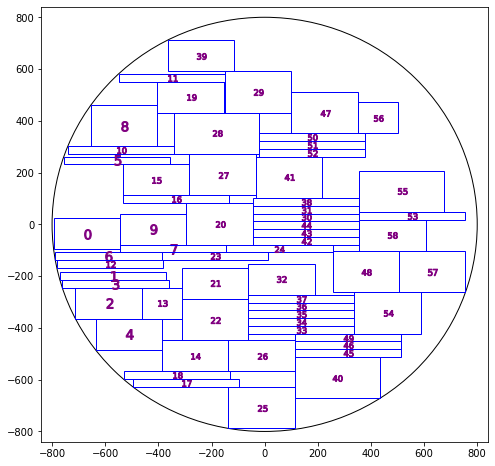

6 left 22660


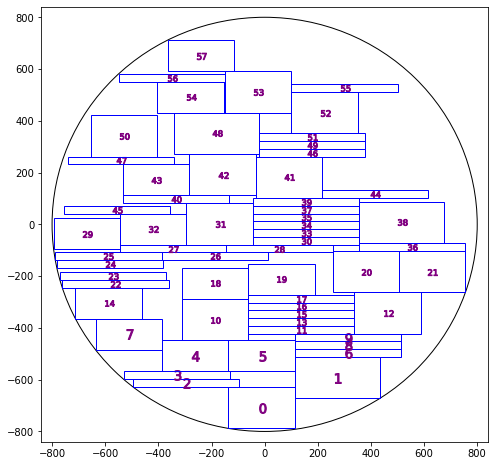

6 down 22920


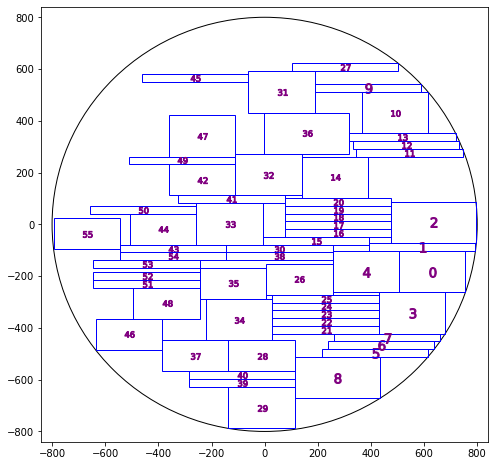

6 right 22840


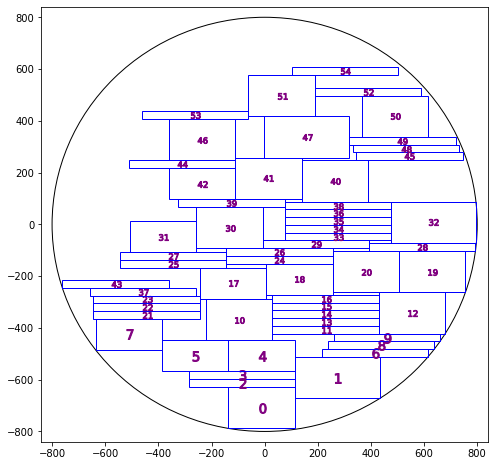

7 down 24040


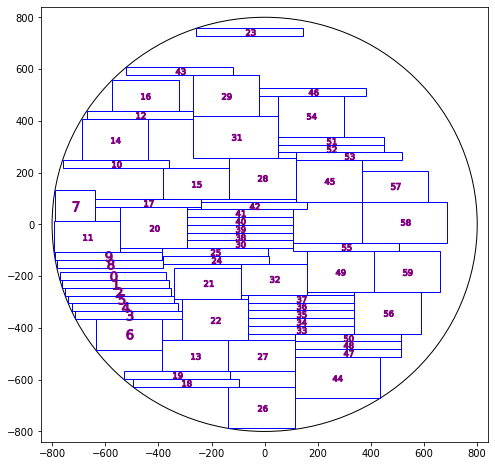

7 left 24420


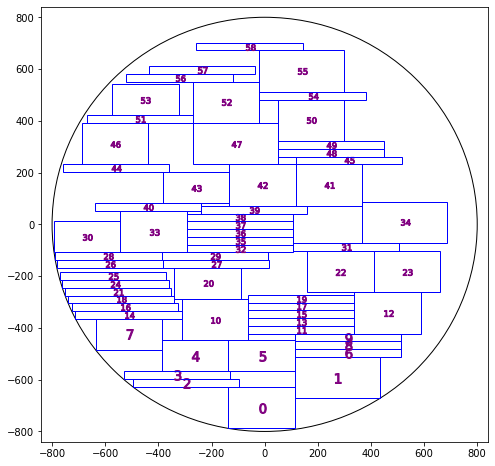

7 down 24860


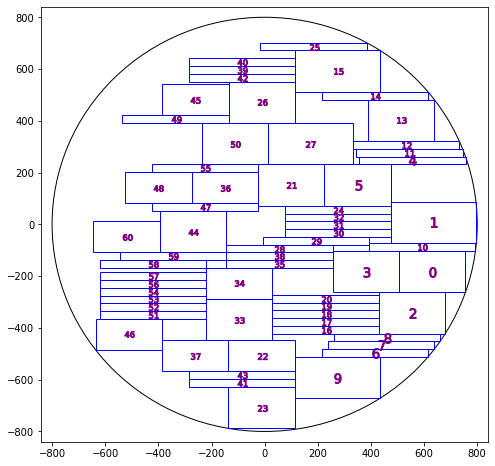

7 right 25340


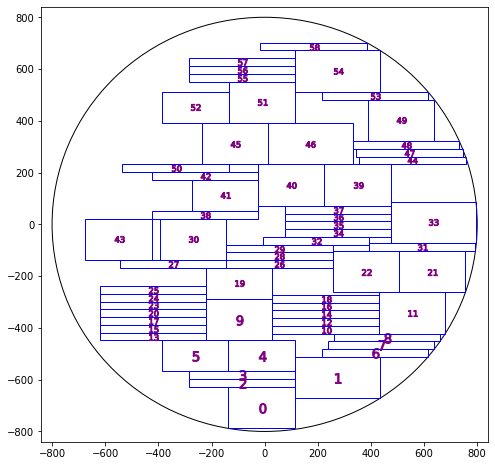

8 down 26460


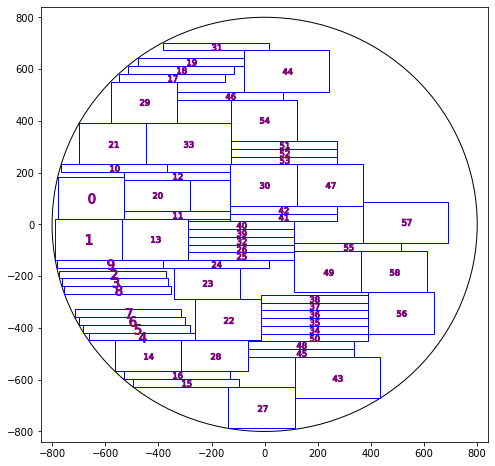

8 left 27500


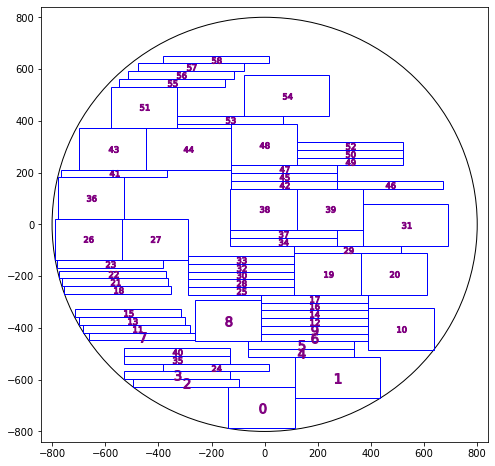

8 down 28120


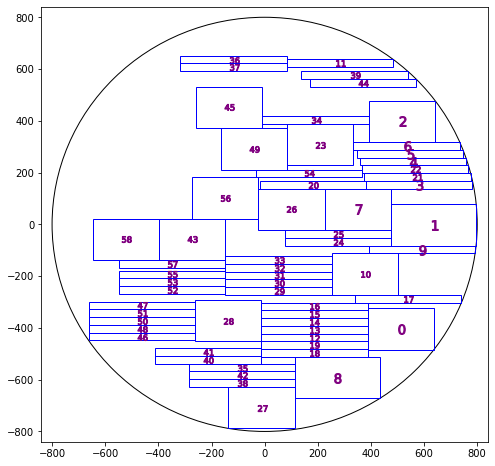

8 right 28680


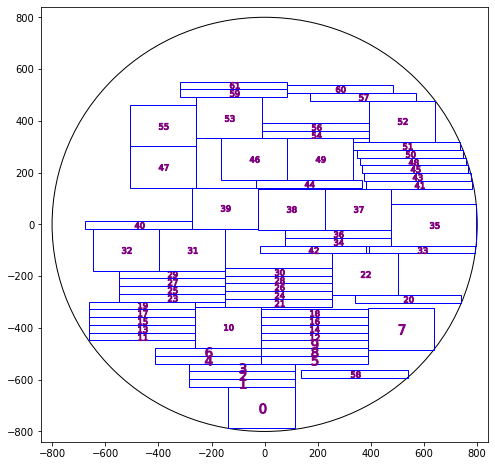

9 down 28680


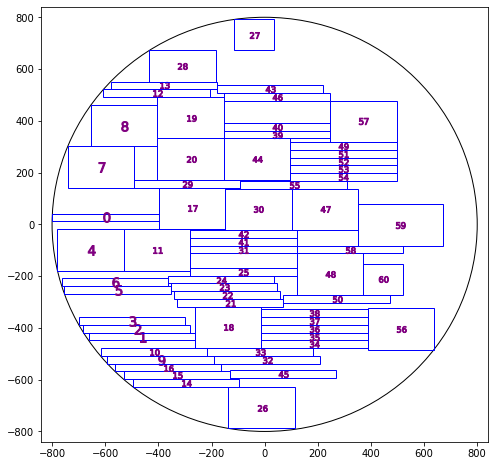

9 left 27760


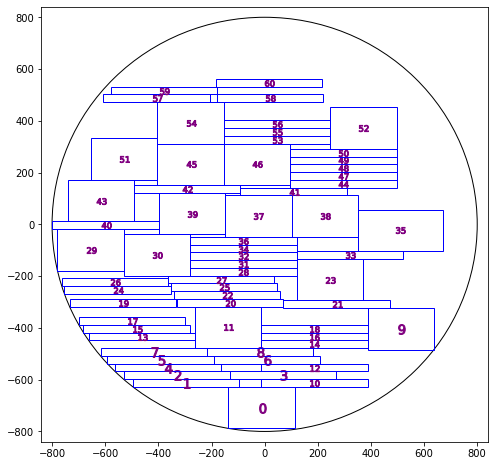

9 down 29640


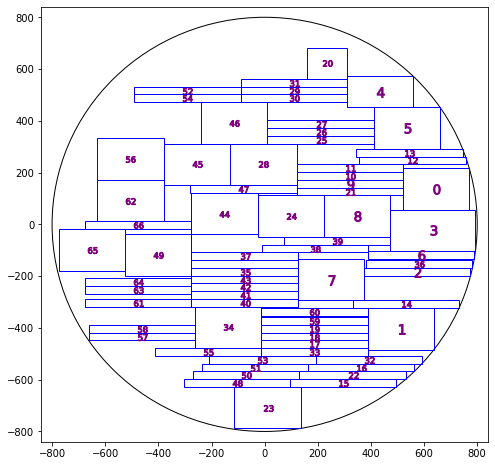

9 right 30420


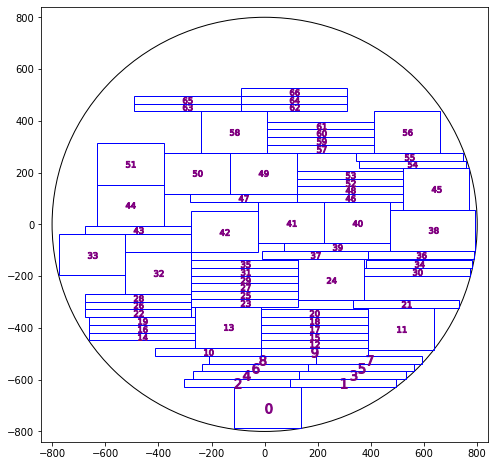

10 down 31260


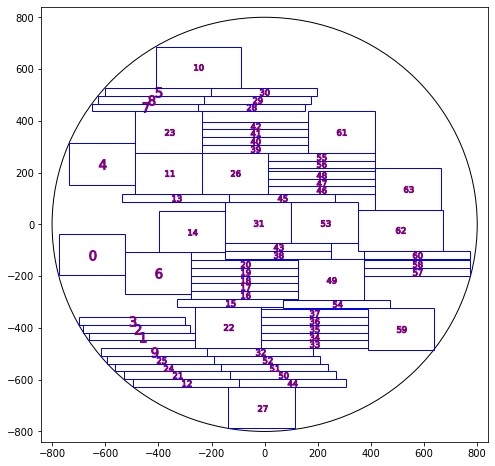

10 left 30940


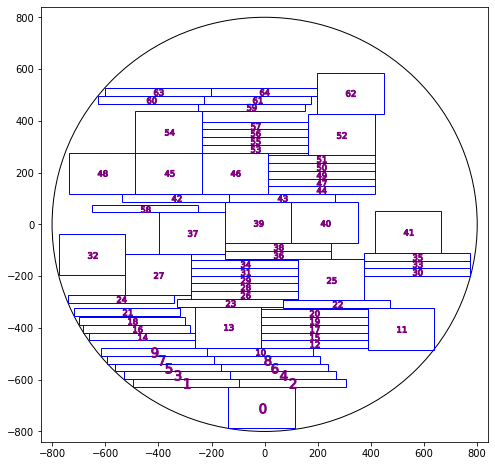

10 down 29580


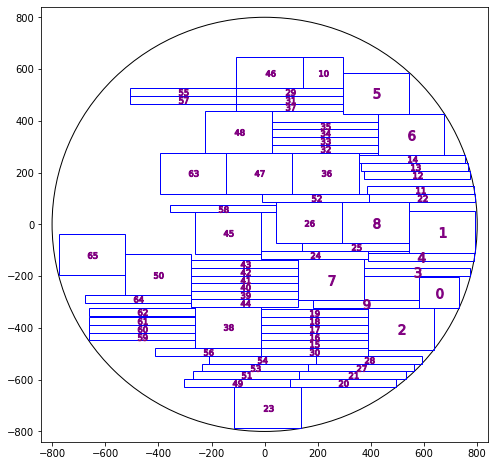

10 right 30140


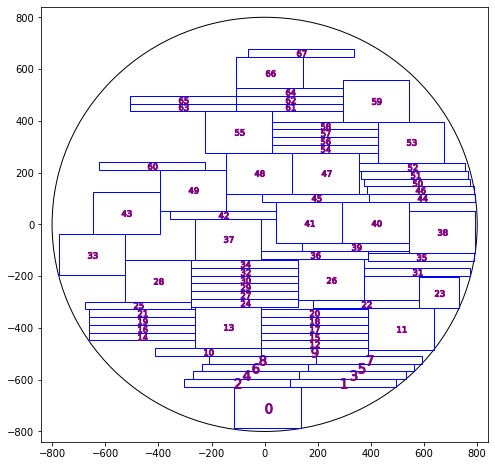

11 down 30580


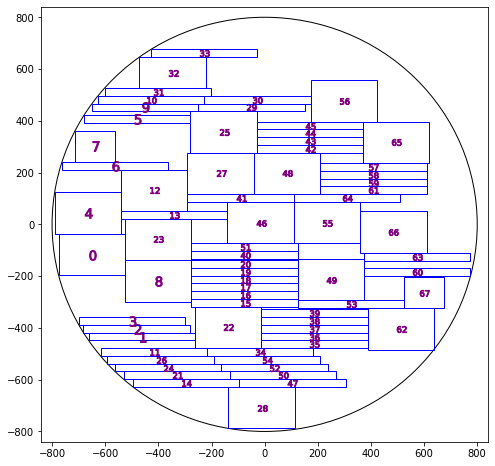

11 left 29700


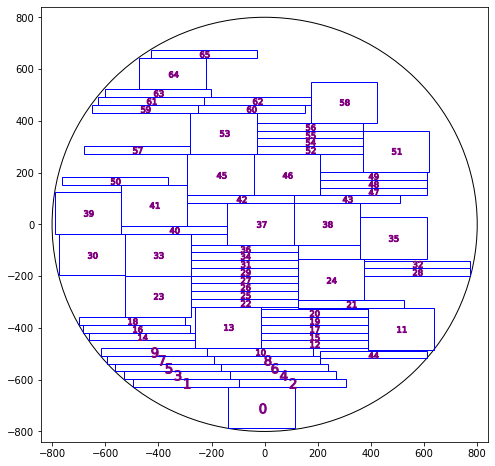

11 down 31440


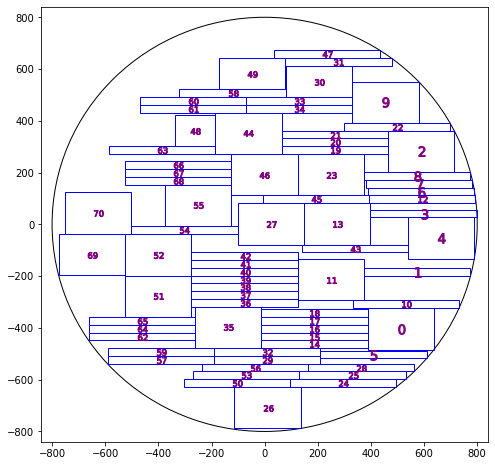

11 right 31360


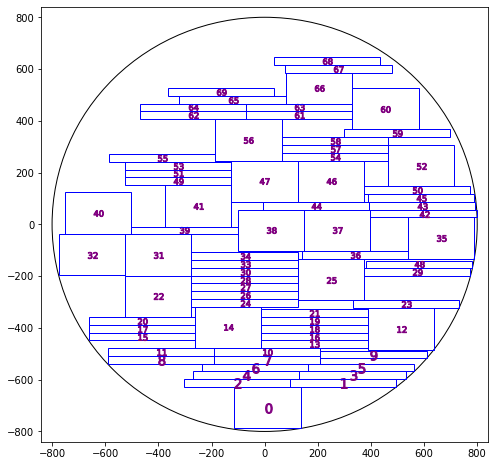

12 down 32060


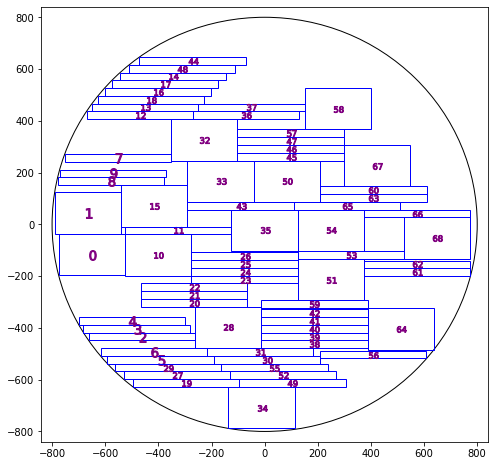

12 left 31300


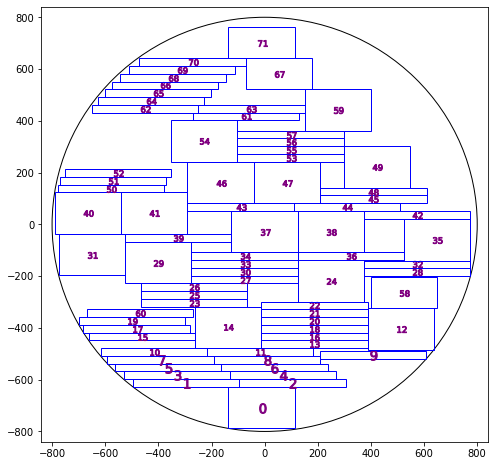

12 down 31360


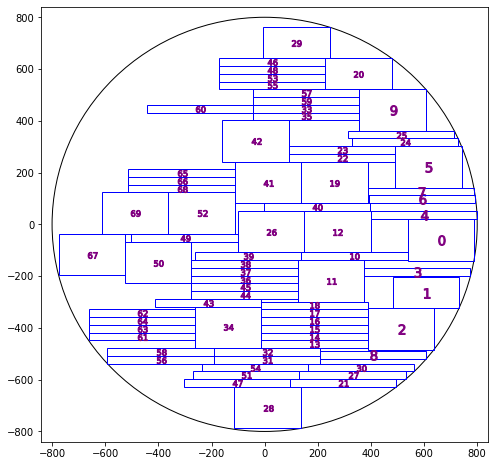

12 right 31180


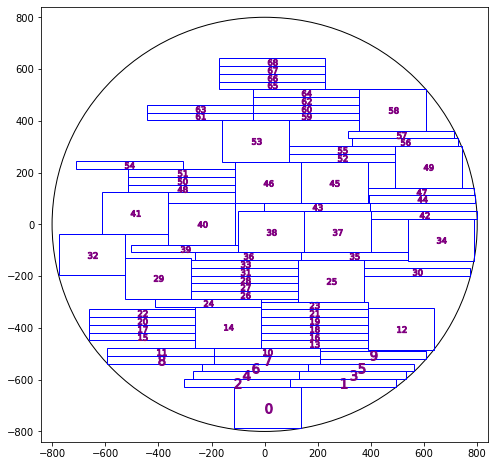

13 down 31900


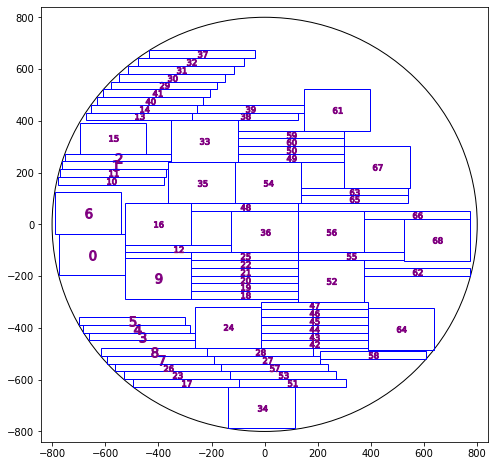

13 left 30700


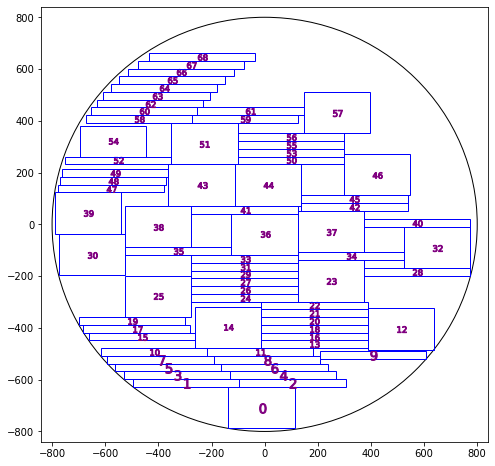

13 down 31220


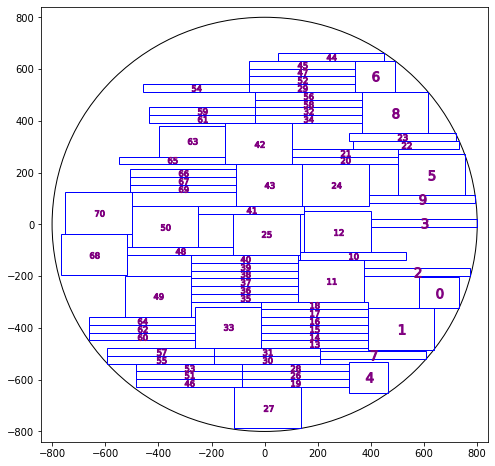

13 right 30720


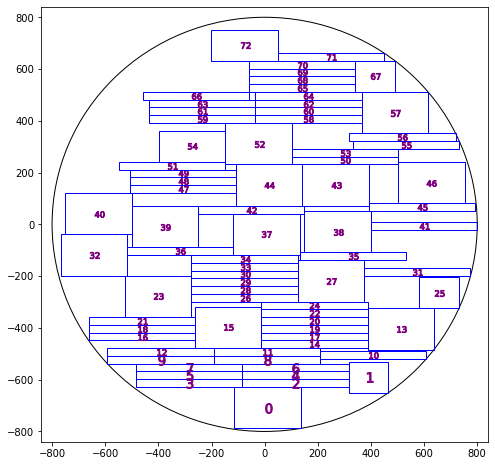

14 down 30640


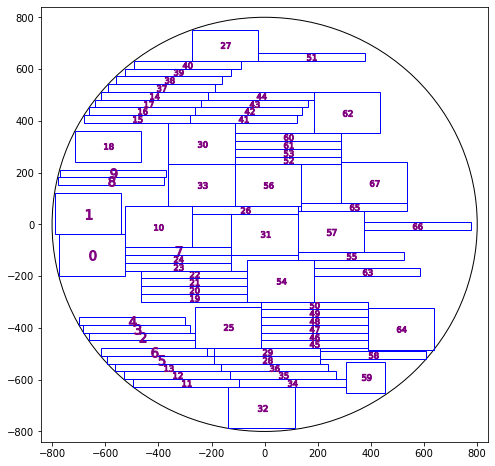

14 left 31480


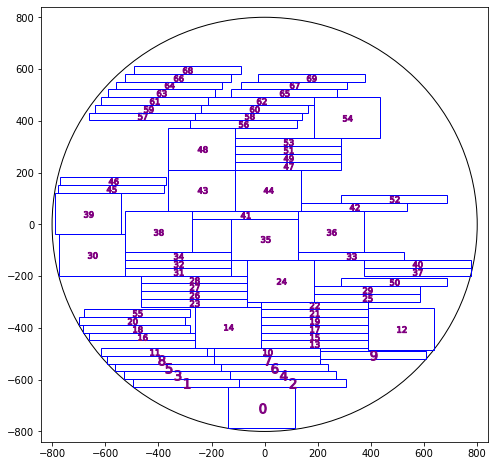

14 down 31720


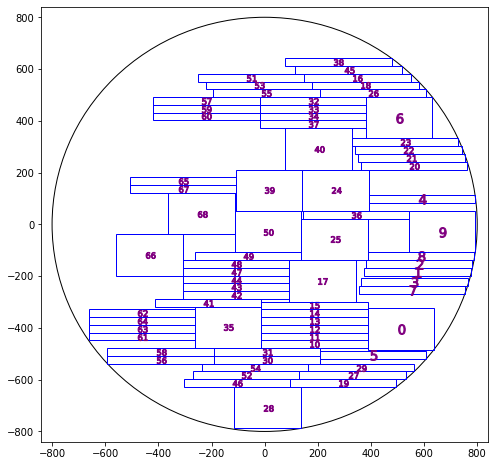

14 right 34140


In [413]:
radius = 800
child = generate_initial(radius, rectangles)
for i in range(15):
    for ax in ['down', 'left', 'down', 'right']:
        child = delete_low_value(child, 5)
        child = shuffle(child, radius, ax)
        show_individual(child, radius)
        child = populate(child, radius, ax, random.randint(100, 500))
        print(i, ax, eval_fun(child))


In [417]:
class CuttingStock:
    def __init__(self, rectangles, radius, population_size = 100, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000):
        self.population_size = population_size
        self.elitism_ratio = elitism_ratio
        self.population = [generate_initial(radius, rectangles) for _ in range(population_size)]
        self.target = target
        self.reproduction_ratio = reproduction_ratio
    def iterate(self, iterations):
        for i in range(iterations):
            self.iteration()
        

    def iteration(self):
        reproducing = self.reproduction(self.reproduction_ratio)
        crossover_offspring = self.crossover(reproducing)
        mutated_offspring = self.mutation(crossover_offspring)
        self.survival_selection(mutated_offspring + crossover_offspring)
        
    def reproduction(self, reproduction_ratio):
        fitness_values = np.array(list(map(eval_fun, self.population)))
        zip_sorted = sorted(zip(self.population, fitness_values), key = operator.itemgetter(1))
        reproducing = [x for x, _ in zip_sorted[:int(self.reproduction_ratio * self.population_size)]]
        return reproducing

    def crossover(self, reproducing):
        num_parents = len(reproducing)
        offspring = []
        random.shuffle(reproducing)
        for i in range(0, num_parents, 2):
            parent1 = reproducing[i]
            if i+1 == len(reproducing):
                parent2 = reproducing[0]
            else:
                parent2 = reproducing[i+1]
            # crossover angles
            a = random.uniform(0, 2*math.pi)
            b = random.uniform(0, 2*math.pi)
            parent1_a, parent1_b = cut_circle(parent1, a, b)
            parent2_a, parent2_b = cut_circle(parent2, a, b)
            child1 = list(parent1_a) + list(parent2_b)
            child2 = list(parent1_b) + list(parent2_a)

            for child in [child1, child2]:
                for i, g in reversed(list(enumerate(child))):

                    if any([rect_overlap2(g,r) for r in child if not (r is g)]):
                        del child[i]

                offspring.append(child)
        return(offspring)
    
    def optimum(self):
        values = np.array(list(map(eval_fun, self.population)))
        return self.population[np.argmax(values)]


    def mutation(self, offspring):
        mutated = []
        for child in offspring:
            if random.random() < 0.4:
                axes = random.sample(['down', 'left', 'right'], 1)
                for ax in axes:
                    child = delete_low_value(child, 5)
                    child = shuffle(child, radius, ax)
                    child = populate(child, radius, ax, random.randint(100, 500))
            mutated.append(child)
        return mutated


    def survival_selection(self, offspring):
        fitness_values = np.array(list(map(eval_fun, self.population)))
        offspring_fitness = np.array(list(map(eval_fun, offspring)))
        combined_population = self.population + offspring
        combined_fitness = np.concatenate((fitness_values, offspring_fitness))
        zip_sorted = list(reversed(sorted(zip(combined_population, combined_fitness), key = operator.itemgetter(1))))

        # elite = [x for x, _ in zip_sorted[:int(self.population_size * self.elitism_ratio)]]
        # zip_sorted = zip_sorted[int(self.population_size * self.elitism_ratio):]

        survivors = [x for x, _ in zip_sorted[:self.population_size]]
        self.population = survivors
        return


def eval_fun(genome):
    return(sum([gene.value for gene in genome]))

In [ ]:
 # IMPORT DATA R = 800 30000
rectangles = pd.read_csv('./cutting/r800.csv', header=None, names = ['width', 'height', 'value'])
radius = 800

1 11100
2 13960
3 16560
4 16680
5 16680
6 16680
7 18440
8 18440
9 18440
10 18440


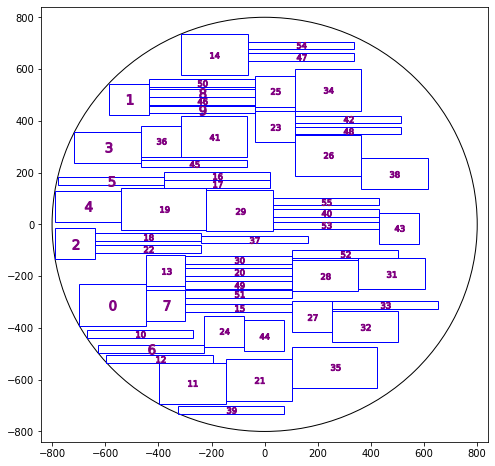

11 18440
12 18440
13 19120
14 19120
15 19120
16 19360
17 19360
18 19360
19 19360
20 19360


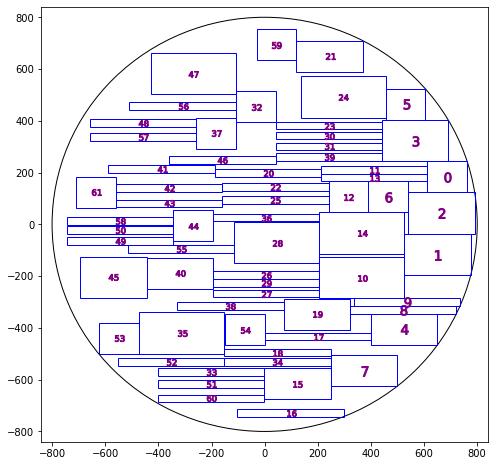

21 20440
22 20440
23 20440
24 20440
25 20440
26 20440
27 20440
28 20440
29 20860
30 20860


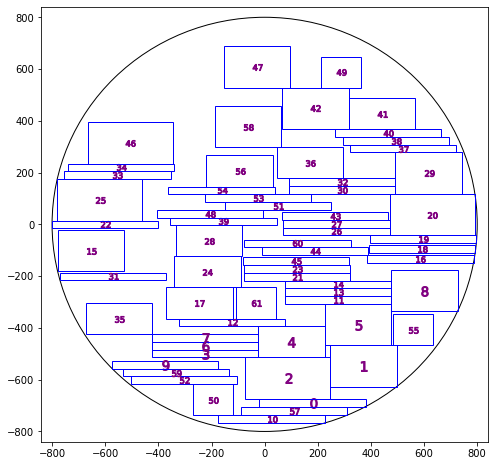

31 22960
32 22960
33 22960
34 22960
35 22960
36 22960
37 23480
38 23520
39 24320
40 24320


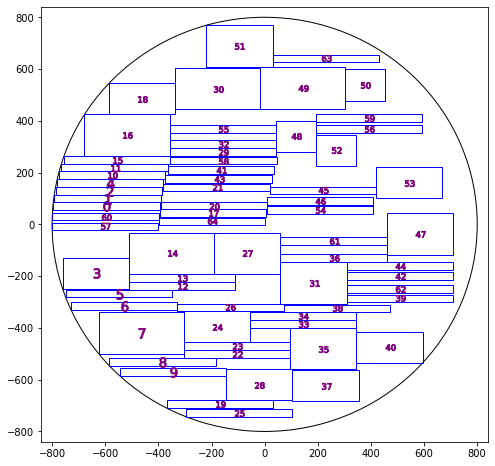

41 24320
42 24320
43 24320
44 24320
45 24320
46 24320
47 24320
48 26120
49 26120
50 26120


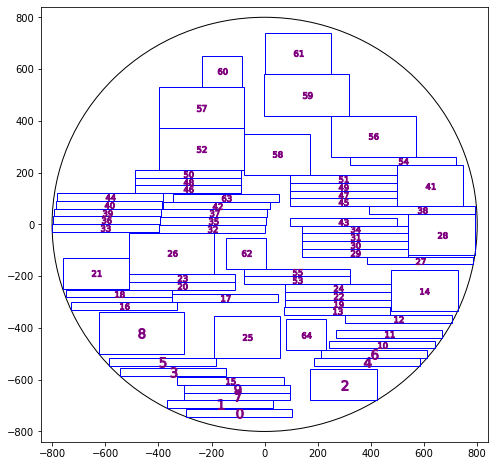

51 26120
52 26120
53 26120
54 26120
55 26120
56 26120
57 27060
58 27060
59 27060
60 27060


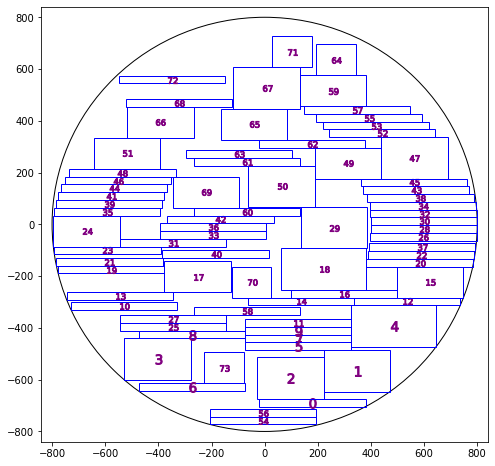

61 27060
62 27060
63 27180
64 27180
65 27180
66 27520
67 27520
68 27640
69 29740
70 29740


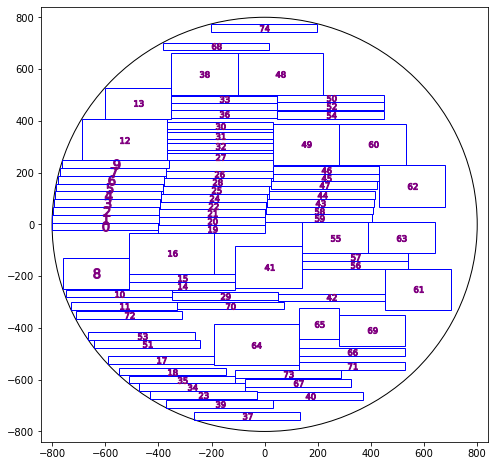

71 29740
72 29740
73 29740
74 29740
75 29740
76 29740
77 29740
78 29740
79 29740
80 29740


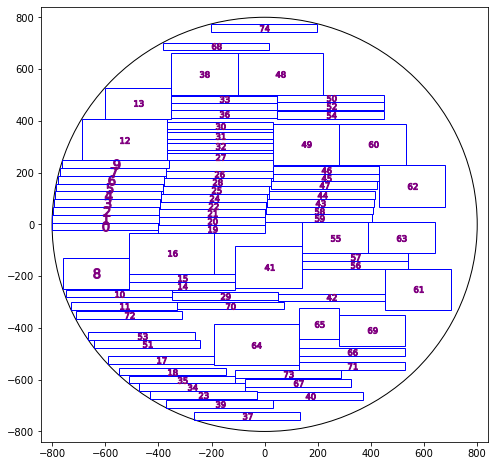

81 29740
82 29740
83 30220
84 30280
85 31140
86 31140
87 31140
88 31140
89 31800
90 31800


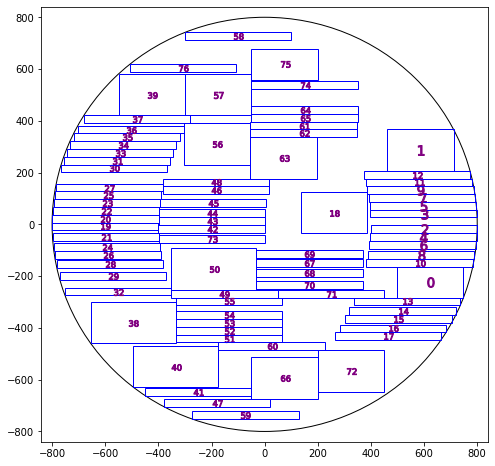

91 32100
92 32100
93 33400
94 33400
95 33400
96 33400
97 33460
98 33460
99 33460
100 33460


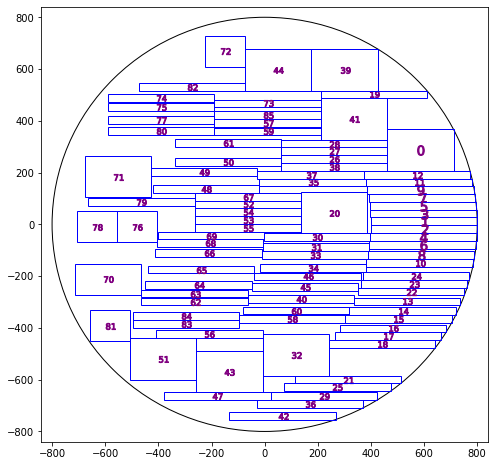

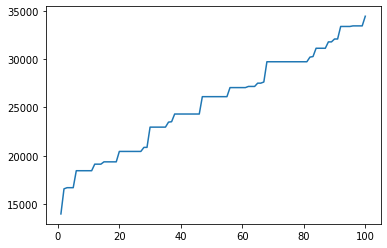

In [419]:
alg = CuttingStock(rectangles, radius = radius, population_size = 100, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000)
best = []
for i in range(1,101):
    print(i, eval_fun(alg.population[0]))
    alg.iterate(1)
    best.append(eval_fun(alg.population[0]))
    if i % 10 == 0:
        show_individual(alg.population[0], radius)
plt.plot(np.arange(1,101), best)

In [420]:
 # IMPORT DATA R = 850 
rectangles = pd.read_csv('./cutting/r850.csv', header=None, names = ['width', 'height', 'value'])
radius = 850

1 115290
2 216150
3 216150
4 235280
5 235280
6 235280
7 235280
8 260090
9 260090
10 260090


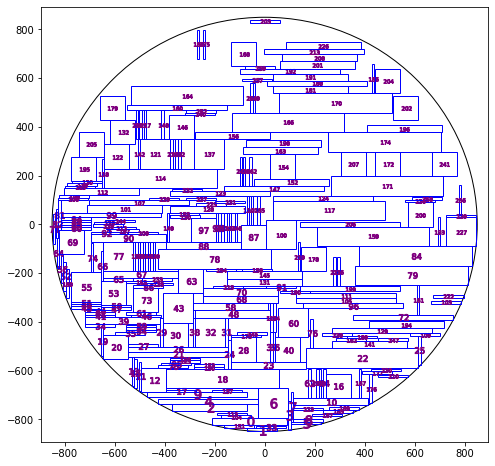

11 260090
12 260090
13 260090
14 260090
15 260090
16 260090
17 260090
18 260090
19 260090
20 260090


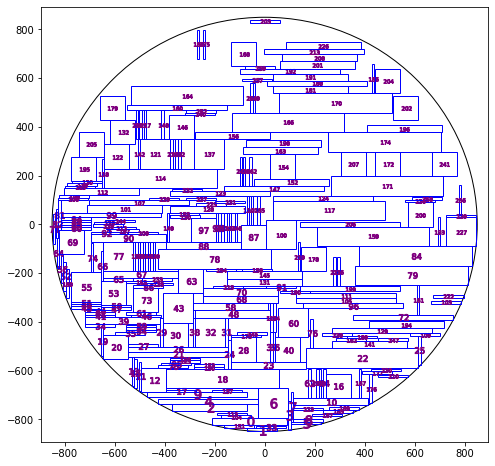

21 260090
22 260090
23 260090
24 260090
25 260090
26 260090
27 260090
28 260090
29 260090
30 274420


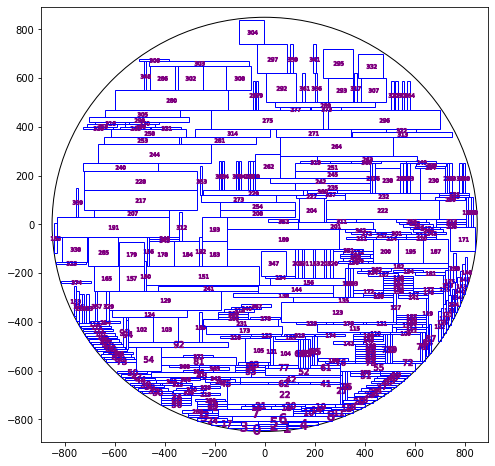

31 274420
32 274420
33 274420
34 274420
35 274420
36 274420
37 274420
38 274420
39 274420
40 274420


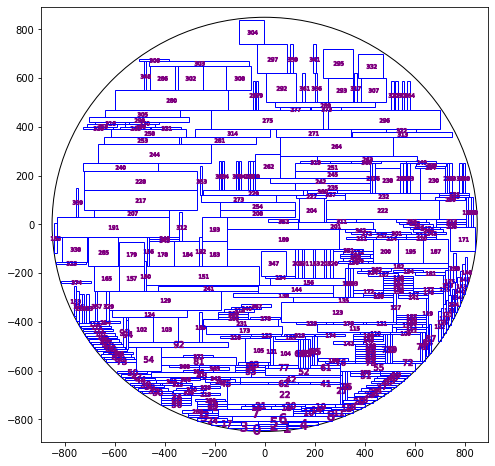

41 274420
42 274420
43 274420
44 274420
45 274420
46 274420
47 274420
48 274420
49 274420
50 274420


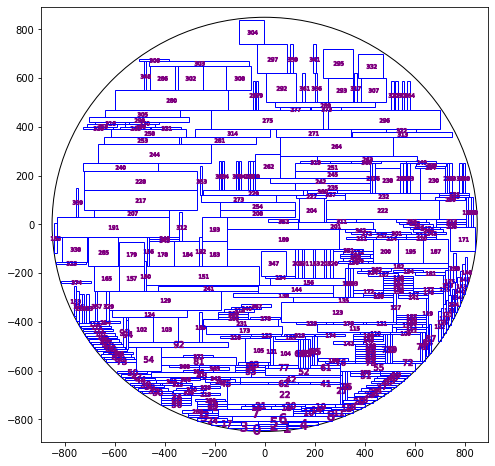

51 274420
52 274420
53 274420
54 274420
55 274420
56 274420
57 275820
58 275820
59 279080
60 283750


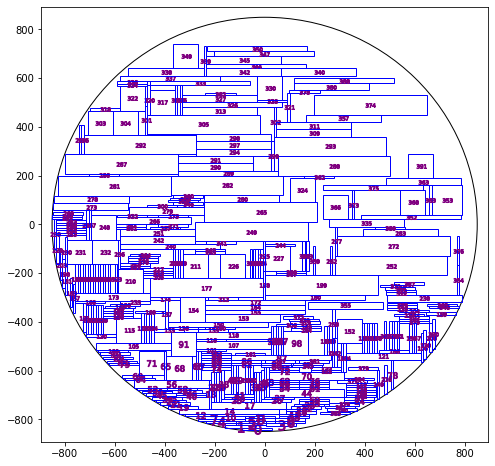

61 283750
62 283750
63 286660
64 298510
65 298510
66 298510
67 298510
68 298510
69 298510
70 298510


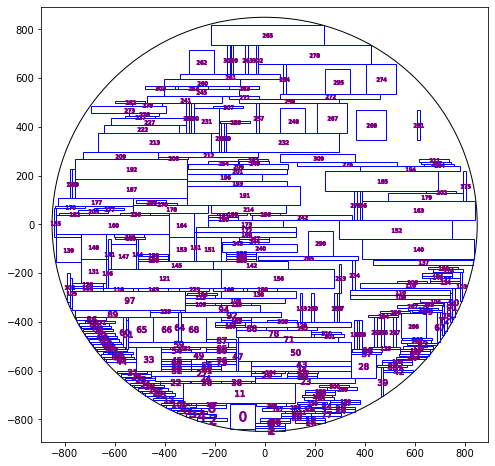

71 298510
72 298510
73 298510
74 298510
75 298510
76 298510
77 298510
78 298510
79 298510
80 300270


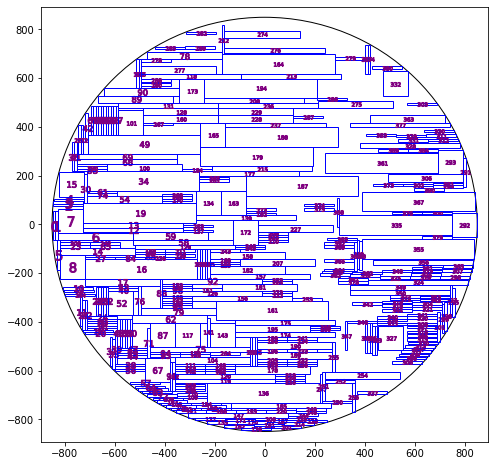

81 300270
82 300270
83 300270
84 300270
85 300270
86 300270
87 300270
88 300270
89 300270
90 300270


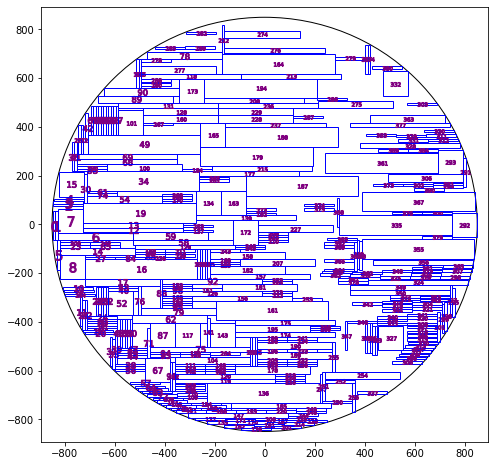

91 300270
92 300780
93 300780
94 300780
95 300780
96 300780
97 300780
98 300780
99 300780
100 300780


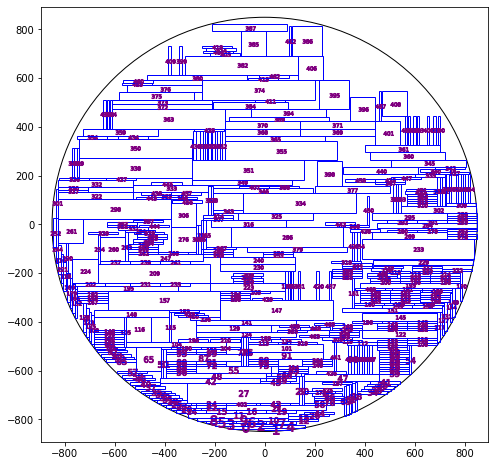

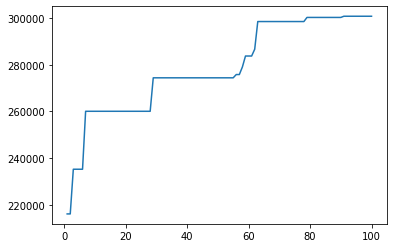

In [421]:
alg = CuttingStock(rectangles, radius = radius, population_size = 100, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000)
best = []
for i in range(1,101):
    print(i, eval_fun(alg.population[0]))
    alg.iterate(1)
    best.append(eval_fun(alg.population[0]))
    if i % 10 == 0:
        show_individual(alg.population[0], radius)
plt.plot(np.arange(1,101), best)

In [422]:
 # IMPORT DATA R = 1000 17500
rectangles = pd.read_csv('./cutting/r1000.csv', header=None, names = ['width', 'height', 'value'])
radius = 1000

1 10740
2 16600
3 17040
4 17240
5 17260
6 17260
7 17260
8 18140
9 18440
10 18440


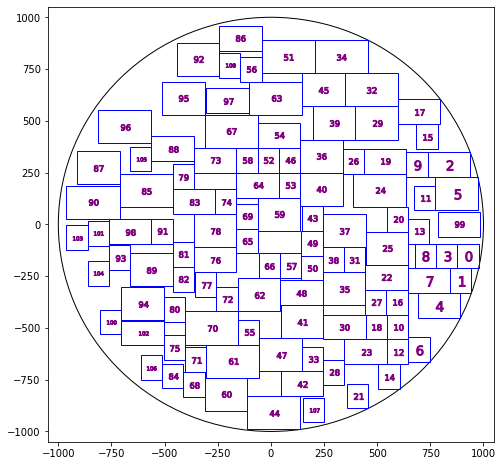

11 18440
12 19100
13 19100
14 19100
15 19180
16 19180
17 19340
18 19340
19 19340
20 19880


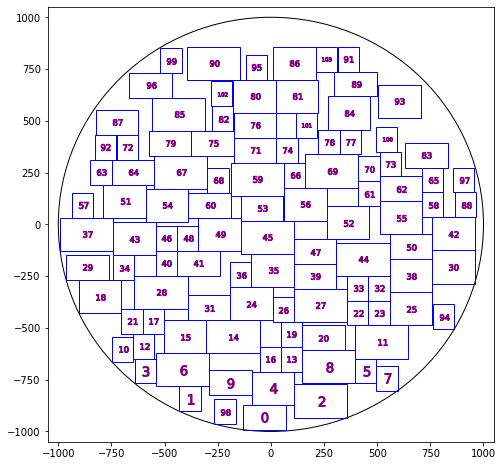

21 19880
22 19880
23 20180
24 20260
25 20260
26 20260
27 20260
28 20260
29 20260
30 20260


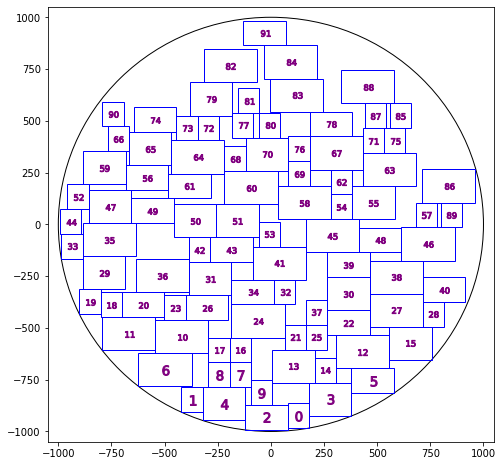

31 20260
32 20260
33 20260
34 20540
35 20540
36 20540
37 20560
38 20560
39 20560
40 20920


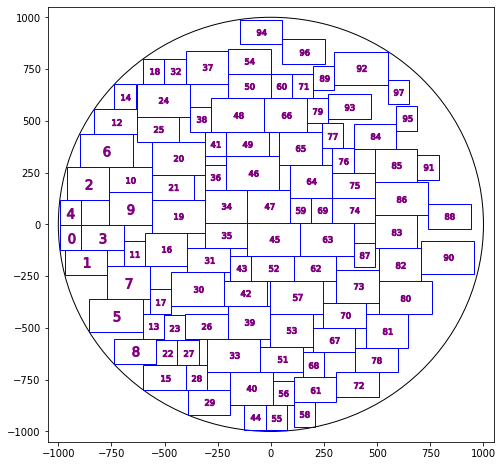

41 20920
42 20920
43 20920
44 20920
45 20920
46 20920
47 20920
48 21060
49 21060
50 21060


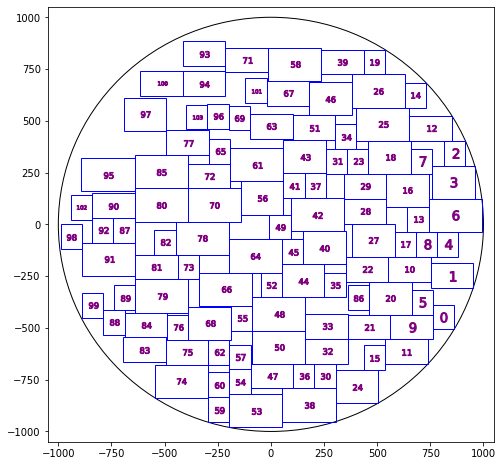

51 21060
52 21060
53 21060
54 21060
55 21060
56 21060
57 21060
58 21060
59 21060
60 21060


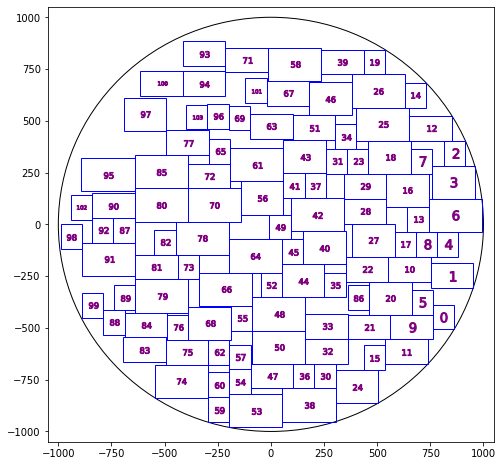

61 21060
62 21060
63 21240
64 21240
65 21780
66 21780
67 21780
68 21780
69 21780
70 21780


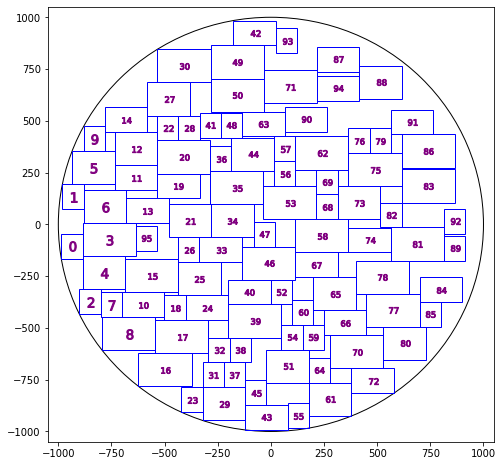

71 21780
72 21780
73 21780
74 21780
75 21780
76 21780
77 21780
78 21780
79 21780
80 21780


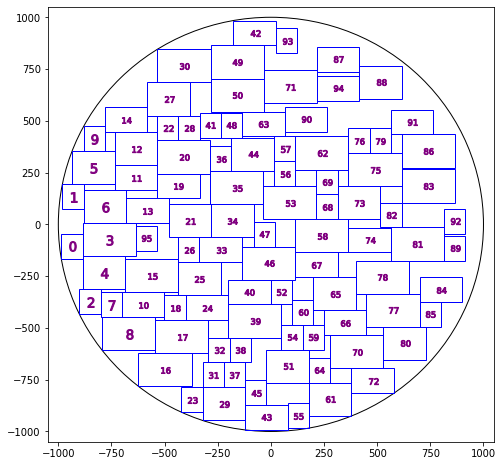

81 21780
82 21780
83 21780
84 21780
85 21780
86 21780
87 21780
88 21780
89 21780
90 21780


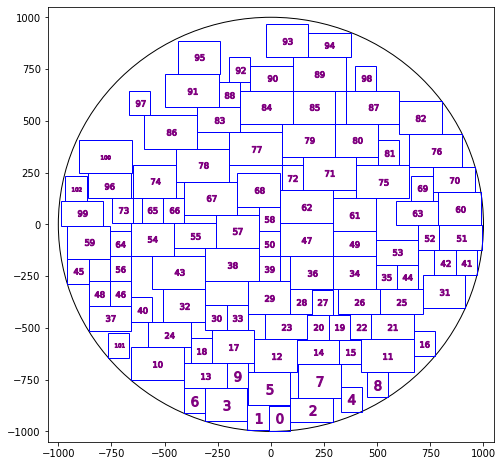

91 21780
92 21780
93 21780
94 21780
95 22000
96 22000
97 22000
98 22000
99 22000
100 22000


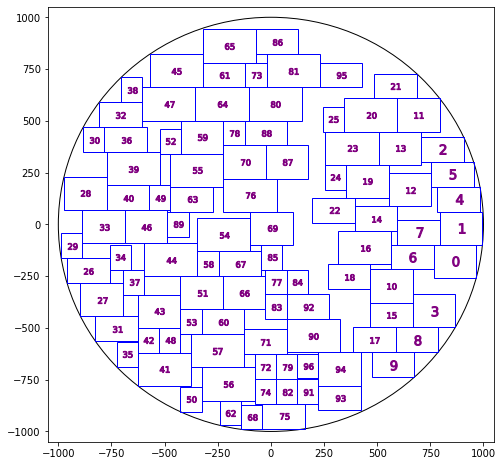

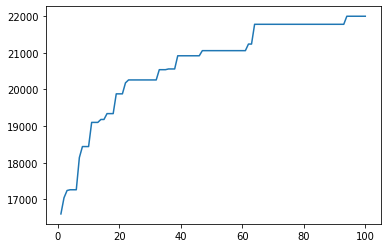

In [423]:
alg = CuttingStock(rectangles, radius = radius, population_size = 100, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000)
best = []
for i in range(1,101):
    print(i, eval_fun(alg.population[0]))
    alg.iterate(1)
    best.append(eval_fun(alg.population[0]))
    if i % 10 == 0:
        show_individual(alg.population[0], radius)
plt.plot(np.arange(1,101), best)

In [424]:
 # IMPORT DATA R = 1100 25000
rectangles = pd.read_csv('./cutting/r1100.csv', header=None, names = ['width', 'height', 'value'])
radius = 1100

1 9620
2 15820
3 17840
4 18300
5 18300
6 18300
7 18320
8 19100
9 19480
10 19480


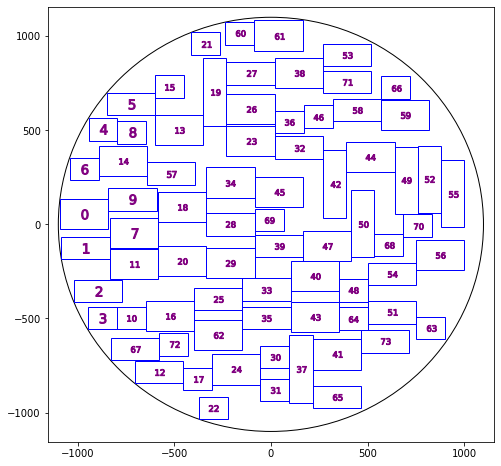

11 19480
12 19480
13 19480
14 19480
15 19480
16 19480
17 21260
18 21260
19 21260
20 21260


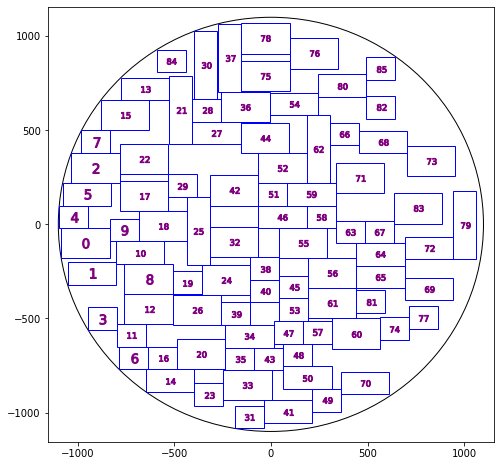

21 21260
22 21460
23 21460
24 21460
25 21460
26 21560
27 21560
28 21560
29 21920
30 21920


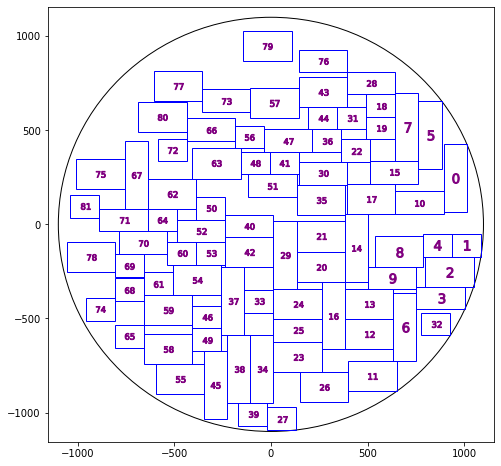

31 21920
32 22200
33 22200
34 22200
35 22200
36 22200
37 22900
38 22900
39 22900
40 22900


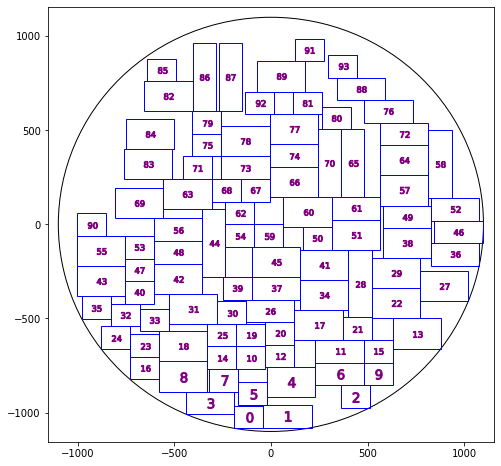

41 22900
42 22900
43 22900
44 22900
45 24140
46 24140
47 24140
48 24140
49 24140
50 24140


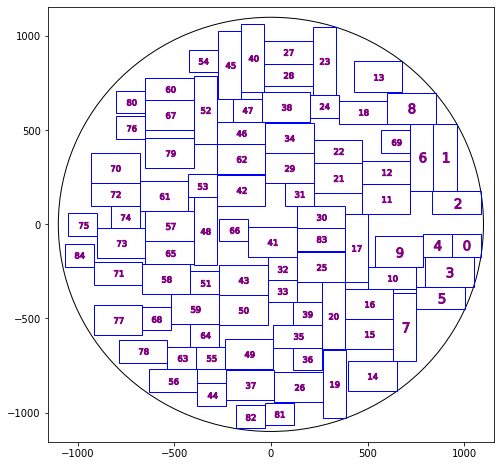

51 24140
52 24140
53 24500
54 24500
55 24500
56 24500
57 24500
58 24500
59 24500
60 24500


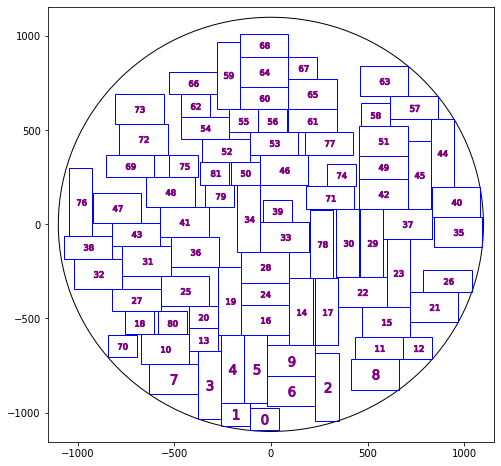

61 24760
62 24760
63 25000
64 25000
65 25380
66 25380
67 25380
68 25380
69 25380
70 25380


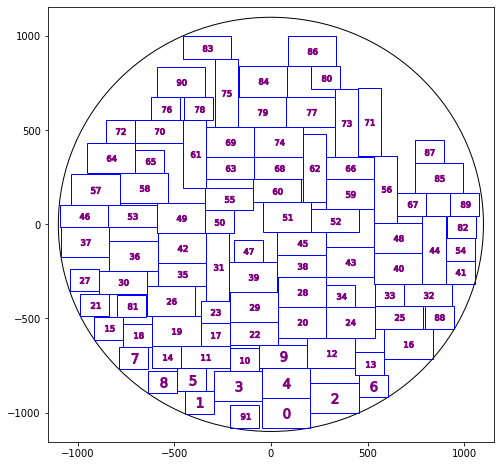

71 25380
72 25380
73 25380
74 25380
75 25380
76 25480
77 25480
78 25480
79 25480
80 25480


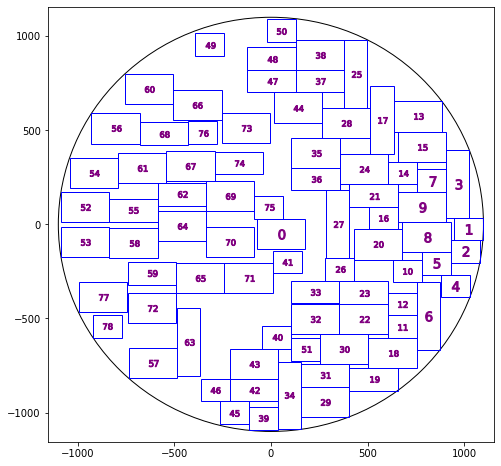

81 25480
82 25480
83 26020
84 26020
85 26020
86 26020
87 26020
88 26020
89 26020
90 26020


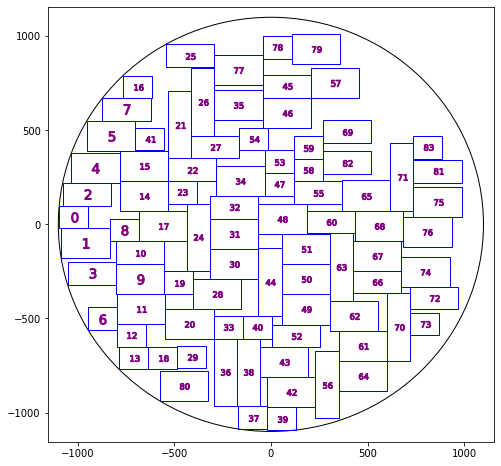

91 26020
92 26020
93 26740
94 26740
95 26740
96 27400
97 27400
98 27400
99 27400
100 27400


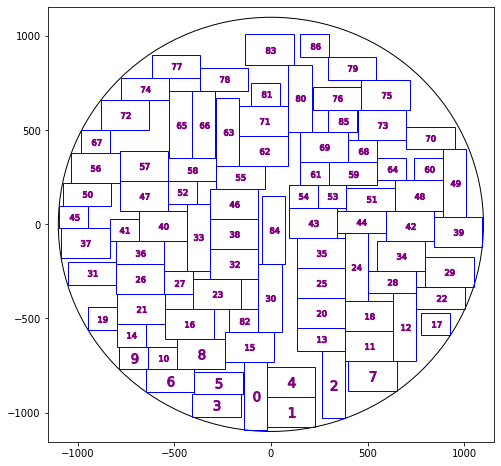

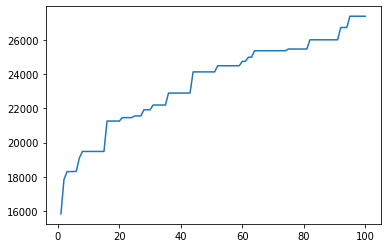

In [425]:
alg = CuttingStock(rectangles, radius = radius, population_size = 100, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000)
best = []
for i in range(1,101):
    print(i, eval_fun(alg.population[0]))
    alg.iterate(1)
    best.append(eval_fun(alg.population[0]))
    if i % 10 == 0:
        show_individual(alg.population[0], radius)
plt.plot(np.arange(1,101), best)

In [426]:
 # IMPORT DATA R = 1200 30000
rectangles = pd.read_csv('./cutting/r1200.csv', header=None, names = ['width', 'height', 'value'])
radius = 1200

1 13200
2 25100
3 25140
4 25140
5 25140
6 25160
7 25500
8 27300
9 27300
10 27500


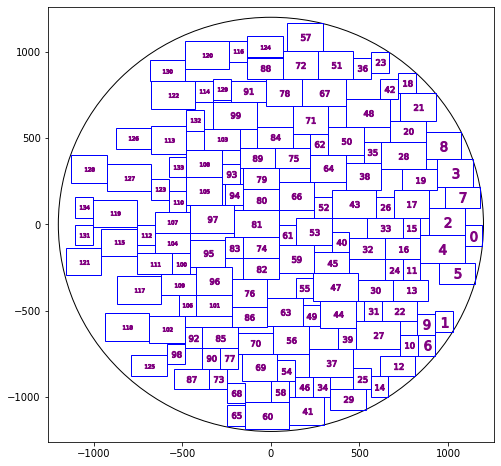

11 27500
12 27820
13 27820
14 28220
15 28220
16 28220
17 28220
18 29520
19 29520
20 29520


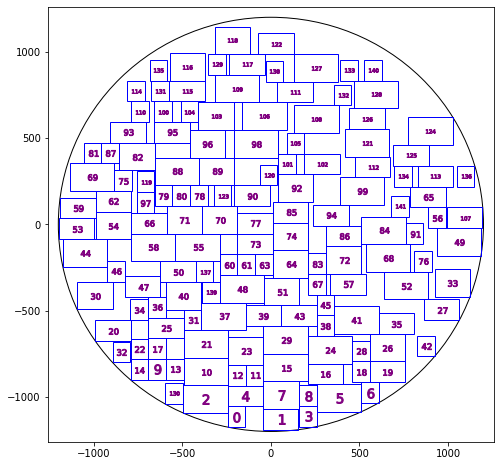

21 29520
22 29520
23 29520
24 29520
25 29520
26 29520
27 29520
28 29520
29 29520
30 29520


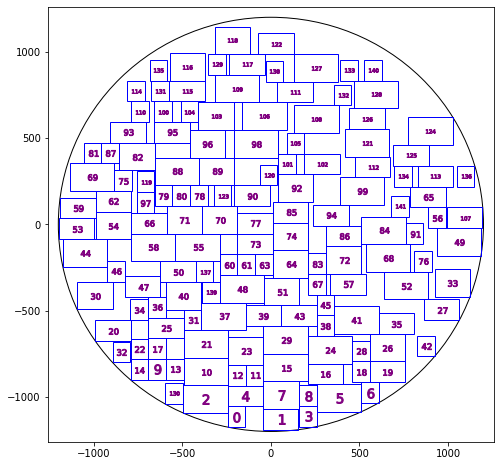

31 29520
32 29520
33 29520
34 29520
35 29520
36 29520
37 29520
38 30220
39 30340
40 30340


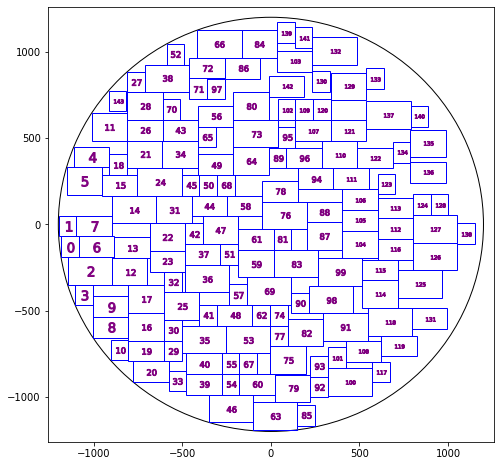

41 30340
42 30340
43 30340
44 30340
45 30340
46 30340
47 30340
48 30340
49 30440
50 30500


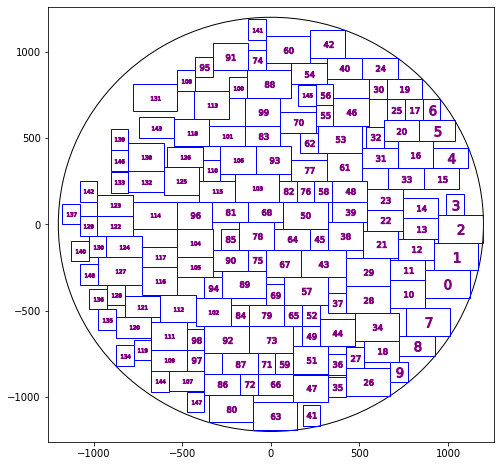

51 30500
52 30640
53 30640
54 30640
55 30640
56 30640
57 30640
58 30640
59 30640
60 30640


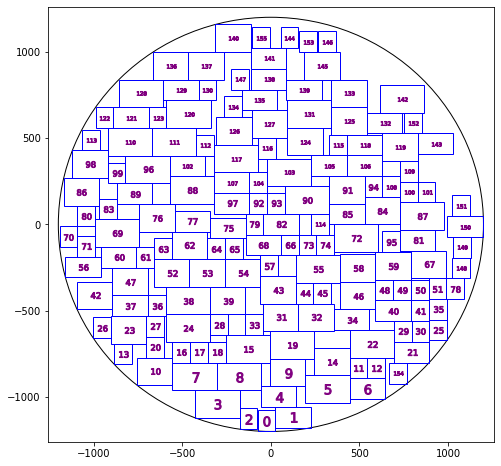

61 30820
62 30820
63 30820
64 30820
65 30820
66 30820
67 30820
68 30820
69 31200
70 31200


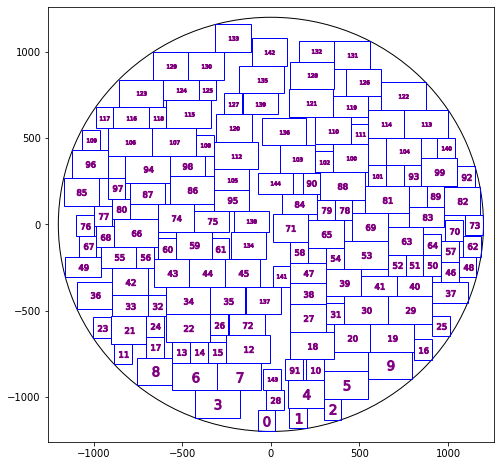

71 32180
72 32180
73 32180
74 32180
75 32180
76 32180
77 32180
78 32180
79 32180
80 32180


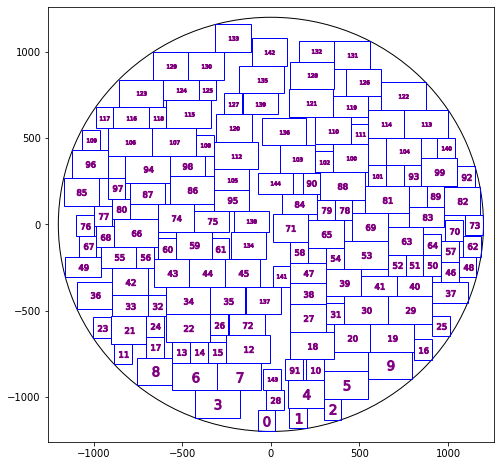

81 32180
82 32180
83 32180
84 32180
85 32180
86 32180
87 32180
88 32180
89 32180
90 32180


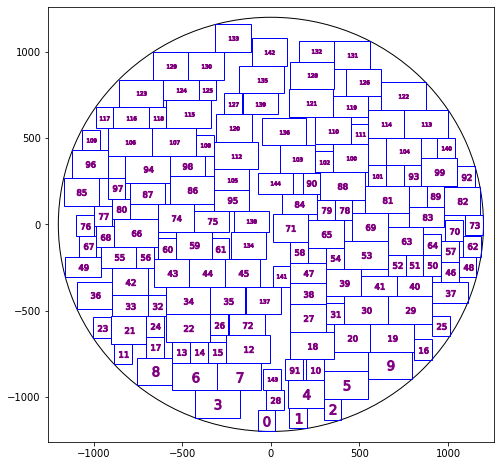

91 32180
92 32180
93 32720
94 32720
95 32720
96 32720
97 32720
98 32720
99 32720
100 32720


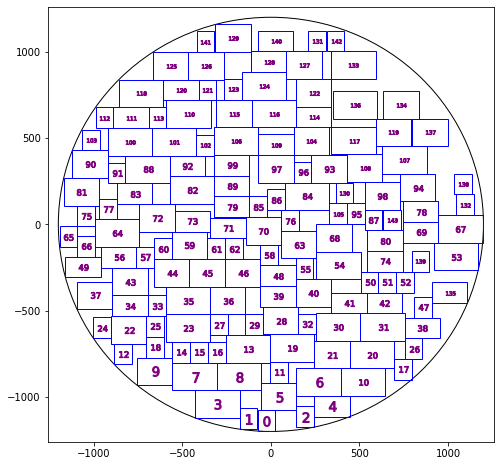

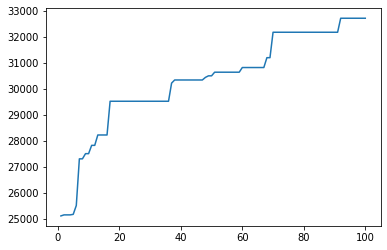

In [427]:
alg = CuttingStock(rectangles, radius = radius, population_size = 100, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000)
best = []
for i in range(1,101):
    print(i, eval_fun(alg.population[0]))
    alg.iterate(1)
    best.append(eval_fun(alg.population[0]))
    if i % 10 == 0:
        show_individual(alg.population[0], radius)
plt.plot(np.arange(1,101), best)

plot with lines

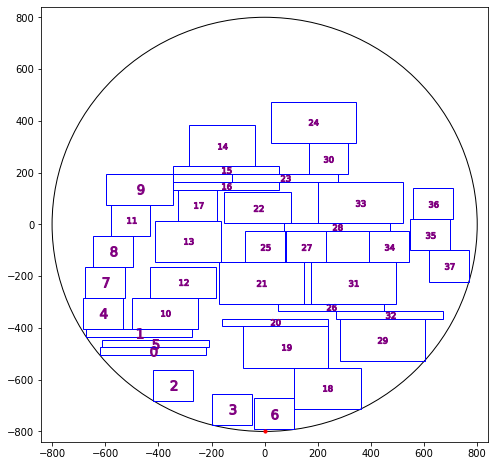

38


In [87]:
radius = 800
genes = genome
fig, ax = plt.subplots(figsize = (8,8))
plt.xlim([-radius*1.05, radius*1.05])
plt.ylim([-radius*1.05, radius*1.05])

ax.add_patch(plt.Circle((0,0), radius, fill = False))
genes = sorted(genes, key = lambda gene: gene.x + math.sqrt( radius**2 - (gene.y)**2) if gene.y < -gene.height/2 else gene.x + math.sqrt( radius**2 - (gene.y+gene.height)**2))
for i, gene in enumerate(genes):
    px, py = gene.x, -math.sqrt(radius**2 - (gene.x)**2)
    ax.add_patch(plt.Rectangle((gene.x, gene.y), gene.width, gene.height, fill = False, lw = 1, ec = 'blue'))
    plt.scatter([gene.x+gene.width/2], [gene.y+gene.height/2], c='purple', s = 100, marker = f'${i}$')
    # plt.plot([px, gene.x], [py, gene.y], lw = 1, c = 'black', alpha = 0.4)
    # plt.plot([0,gene.x+gene.width/2], [-radius, gene.y+gene.height/2], lw = 1, c = 'black', alpha = 0.75)
plt.scatter([0], [-radius], c = 'red', s = 10)
plt.show()
print(len(genes))

best for iteration1 scores, 14600
best for iteration2 scores, 25360
best for iteration3 scores, 25360
best for iteration4 scores, 25360
best for iteration5 scores, 25360
best for iteration6 scores, 25360
best for iteration7 scores, 25360
best for iteration8 scores, 27500
best for iteration9 scores, 28120


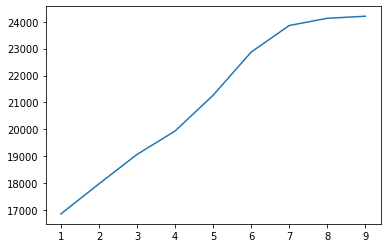

In [428]:
alg = CuttingStock(rectangles, radius = radius, population_size = 25, max_generations=1000, mutation_ratio = 0.2, elitism_ratio = 0.01, reproduction_ratio = 0.5, target = 30000)
best = []
for i in range(1,10):
    print(f"best for iteration{i} scores, {eval_fun(alg.population[0])}")
    alg.iterate(1)
    best.append(np.mean([eval_fun(i) for i in alg.population]))
plt.plot(np.arange(1,10), best)

In [ ]:
próba uniwersalizacji kąta działania

In [ ]:
# angle = 3/2 * math.pi # gravity angle 
# # sort rectangles by their distance to the angle-bound point on the circle
# sorted_genome = sorted( genome, key = lambda rect: ((rect.x + rect.width/2 - px)**2 + (rect.y + rect.height/2 - py)**2))
# # pull rectangles one by one to that point:
# for index, rect in enumerate(sorted_genome):

#     pulling_vec = (px - rect.x - rect.width/2, py - rect.y - rect.height/2)
#     vertices = [(rect.x, rect.y), (rect.x+rect.width, rect.y), (rect.x+rect.width, rect.y+rect.height), (rect.x, rect.y+rect.height)]
#     v = vertices[np.argmin(np.linalg.norm(v-(px, py))) for v in vertices] # vertex closest to the pulling point
 



#     for r2 in sorted_genome[:index]:


        

# sorted_genome[0].x
# def calc_scale(x, y, gx, gy, r): # calculate scale for the normalized gravity vector
#     # g is normalized, so gx = cos(alpha), gy = sin(alpha)
#     lenght = math.sqrt(gx**2 + gy**2)
#     return (-2*(x*gx + y*gy) + math.sqrt(4 * (x**2 * gx**2 + y**2 * gy**2 + (2 * x * y * gx * gy) -  x**2 - y**2 + r**2) )) / 2

# def calc_drop_point(x,y,gx,gy,k): # calculate the point of contact at the circle's edge
#     return(x+k*gx, y+k*gy)

In [ ]:
radius = 800
genes = generate_initial(radius, rectangles)
fig, ax = plt.subplots(figsize = (8,8))
plt.xlim([-radius*1.05, radius*1.05])
plt.ylim([-radius*1.05, radius*1.05])

ax.add_patch(plt.Circle((0,0), radius, fill = False))
genes = sorted(genes, key = lambda gene: gene.y + math.sqrt( radius**2 - (gene.x)**2) if gene.x < -gene.width/2 else gene.y + math.sqrt( radius**2 - (gene.x+gene.width)**2))
for i, gene in enumerate(genes):
    px, py = gene.x, -math.sqrt(radius**2 - (gene.x)**2)
    ax.add_patch(plt.Rectangle((gene.x, gene.y), gene.width, gene.height, fill = False, lw = 1, ec = 'blue'))
    plt.scatter([gene.x+gene.width/2], [gene.y+gene.height/2], c='purple', s = 100, marker = f'${i}$')
    # plt.plot([px, gene.x], [py, gene.y], lw = 1, c = 'black', alpha = 0.4)
    # plt.plot([0,gene.x+gene.width/2], [-radius, gene.y+gene.height/2], lw = 1, c = 'black', alpha = 0.75)
plt.scatter([0], [-radius], c = 'red', s = 10)
plt.show()
print(len(genes))